# Linear Regression Baseline - LB 1.092
In this notebook, we provide a linear regression baseline for Kaggle's GoDaddy Microbusiness Density Forecast Competition. In this competition we are given 3135 timeseries of length 39. This is 39 months of microbusiness density from August 2019 thru October 2022 inclusive. We must predict microbusiness density for the next 8 months November 2022 thru June 2023 inclusive. Each time series is a different county in the United States. Therefore we will make `25080 = 3135 * 8` predictions.

The simplest baseline provided by Tawara is to just predict the last known microbusiness value for each county [here][1]. This achieves LB 1.093. Maybe we can improve this baseline by applying linear regression to the time series that appear to follow a linear trend. There are 486 counties exhibiting a linear trend (with train error less than 10% train range). Below we plot 8 random (out of 3135) time series, and then we plot 8 time series that have a linear trend.

### Updates
In version 1, we assumed linear trend if train error was less than 10% of train range (and achieved LB 1.113). In notebook version 2, 3, 4 we set the threshold to 5%, 3.8%, and 3% respectively (and achieved LB 1.094, 1.093, 1.093). Note in version 4, the threshold only modified one prediction from the "last value" baseline. (Whereas versions 1,2,3 modified 486, 22, 2 respectively).

Ha ha, version 4 beats the "last value" baseline but this isn't a big accomplishment because we only changed one county's predictions. It may have just been lucky actually. In version 5 and 8, we set threshold for linear trend back to 10% (same as version 1). Perhaps there is a way to use linear regression in a more significant way and beat the "last value" baseline more significantly. Stay tuned for future notebook versions!

New update: version 9 beats "last value" baseline by `+0.001` woohoo!. We limited our linear model predictions to counties with population 25,000 or above. This worked well because a trend involving more population should be more likely to continue. The importance of population is explained [here][2]. For local CV, using error threshold 12.8% and population threshold 9,000 is best. Let's make some more LB submissions to see if the same hyperparameters are optimal for LB...

### Version Notes
* version 4 - uses linear regression for 1 prediction (where train error < 3% train range). Achieves LB 1.093 beating the "last value" baseline
* version 5 - uses linear regression for 486 predictions (where train error < 10% train range). Achieves LB 1.113
* version 6 - ensembles 486 linear regression predictions with "last value" at weights 5% and 95%. Achieves LB 1.094
* version 7 - uses 5% threshold (which modifies 22 counties) and scale global prediction total to match global prediction total of "last value" baseline. Achieves LB 1.109
* version 8 - same as version 5. Uses linear regression for 486 predictions (where train error < 10% train range). Achieves LB 1.113
* version 9 - uses 10% threshold and county needs more than 25,000 active. Achieves LB 1.092 (and CV 1.098) and beats "last value" baseline. Woohoo!
* version 10 - uses 10% threshold and county needs more than 9,000 active (CV 1.096). Achieves LB 1.093
* version 11 - same as version 9 but makes code to detect linear trend more readable.

[1]: https://www.kaggle.com/code/ttahara/gd-mdf-last-target-baseline
[2]: https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/373099

# Load Libraries, Train, Test

In [13]:
#pip install statsmodels

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_percentage_error
import seaborn as sns
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
import math
from warnings import simplefilter
simplefilter("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train=pd.read_csv('/content/drive/MyDrive/Data science/kaggle competitions/godaddy microbusiness/train.csv',parse_dates=['first_day_of_month'])
sample_submission=pd.read_csv('/content/drive/MyDrive/Data science/kaggle competitions/godaddy microbusiness/sample_submission.csv')
census=pd.read_csv('/content/drive/MyDrive/Data science/kaggle competitions/godaddy microbusiness/census_starter.csv')
test=pd.read_csv('/content/drive/MyDrive/Data science/kaggle competitions/godaddy microbusiness/test.csv',parse_dates=['first_day_of_month'])
# train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
# #test = test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
train.head()                

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [7]:
train.shape

(122265, 7)

In [8]:
test=test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

# Data EDA
Below we observe that both train and test data have 3135 unique counties (i.e. `cfips`). In the train data, each county has 39 months of data. And in the test data, each county expects us to predict 8 months. By displaying the `min` and `max` dates, we discover that train data ranges from August 2019 thru October 2020 inclusive. And test data ranges from November 2022 thru June 2023 inclusive. We also plot 8 random time series below. We observe that in general, the time series do not have a consistent linear trend.

# Train and Infer Linear Regression
For each of 3135 time series, we model with linear regression and compute the error of train data vs. predicted train data. If the average error is less than 10% of the range of train values, we assume the time series has a linear trend. For these 486 counties we use linear regression to predict test. For the other 2649, we use the last known value in train and the test prediction.

UPDATE in version 9: As an experiment, we will only assume linear trend only if county has more than 25,000 `active`. The train data column `active` indicates the size of the population in county. I think a trend involving more people should be more likely to continue to occur. With this additional restriction, we will use linear model for 32 counties and "last value" for 3103 counties. Let's see what LB it achieves...

## removing outliers 

In [1]:
df_outlier=train.groupby('cfips').microbusiness_density.describe().reset_index()
df_outlier.head()

NameError: ignored

In [ ]:
df_outlier['clips']=(df_outlier['75%']-df_outlier['25%'])*4+ df_outlier['75%']
df_outlier.head()

In [ ]:
df_outlier.loc[df_outlier['max']>df_outlier['clips'],:].head()

In [ ]:
df_train=train.merge(df_outlier,on='cfips')
print(df_train.shape)
df_train.head()

In [ ]:
def final_value(mbd,clips):
    if mbd>clips:
        return clips
    else:
        return mbd

In [ ]:
df_train['mbd_clipped']=df_train.apply(lambda x:final_value(x.microbusiness_density,x.clips),axis=1)
df_train.tail()

In [ ]:
df_train=df_train[['row_id','cfips','county','state','first_day_of_month','mbd_clipped','active']]
df_train.columns=['row_id','cfips','county','state','first_day_of_month','microbusiness_density','active']
df_train.head()

In [ ]:
# train=df_train
# train.shape

# Prediction

In [9]:
DISPLAY =8 
THRESHOLD =0.103  #this is 10.3% same value as 8/78 from old notebook
ACTIVE_THRESHOLD =25_000

unique_cfips =train.cfips.unique() # return unique cflips
x_train =np.arange(39).reshape((-1,1))# return (36,1) x_train arrays 
x_test =np.arange(38,47).reshape((-1,1)) # return (8,1) x_test array

preds = np.zeros((len(unique_cfips),8),dtype='float')
last_preds = np.zeros((len(unique_cfips),8),dtype='float')
lin_trend = 0

In [10]:
R2_score=[]
cfips_bad_r2score=[]
cfips_high_err=[]
cfips_lin=[]
s_list=[]

for i,c in enumerate(unique_cfips):
    df=train.loc[train.cfips==c] # generate data frame for the selected cfips
    model = LinearRegression()
    model.fit(x_train,df.microbusiness_density) # fit a linear model
    p =model.predict(x_train) # predict  
    #append R2_score
    R2_score.append(r2_score(p,df.microbusiness_density))
    # append cfips with bad r2_score
    if r2_score(p,df.microbusiness_density)<0.3:
        cfips_bad_r2score.append(c)
    #append cfi[s with linear trend 
    if r2_score(p,df.microbusiness_density)>0.9:
        cfips_lin.append(c)
    # COMPUTE TRAIN ERROR
    err =p-df.microbusiness_density.values
    rng = df.microbusiness_density.max()-df.microbusiness_density.min()
    
    # DETERMIN IF TIME SERIES IS LINEAR OR NOT
    # create a list of error
    s=0
    for k in range(39): # for each month in the training set we will run the function
        e=np.abs(err[k]) # returns absolute error 
        r=e/rng #error divided by the actual value
        s+=r
    s=s/39 # now S is MAPE mean absolute percentage error
    
    #store ids with high s for further investigation
    if s>0.3:
        cfips_high_err.append(c) 

In [11]:
len(cfips_bad_r2score)

1900

In [30]:
len(cfips_lin)

89

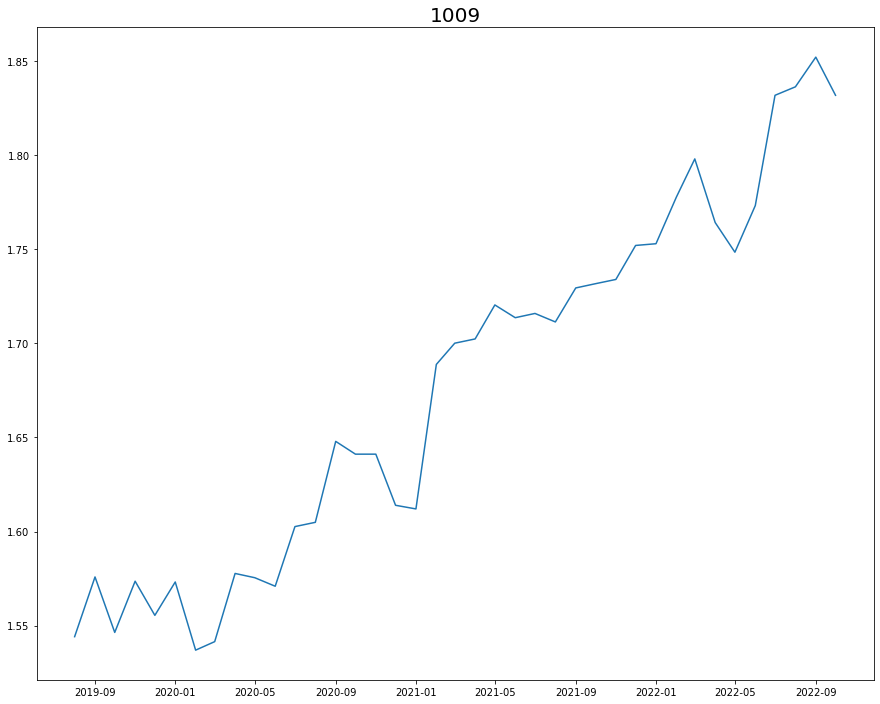

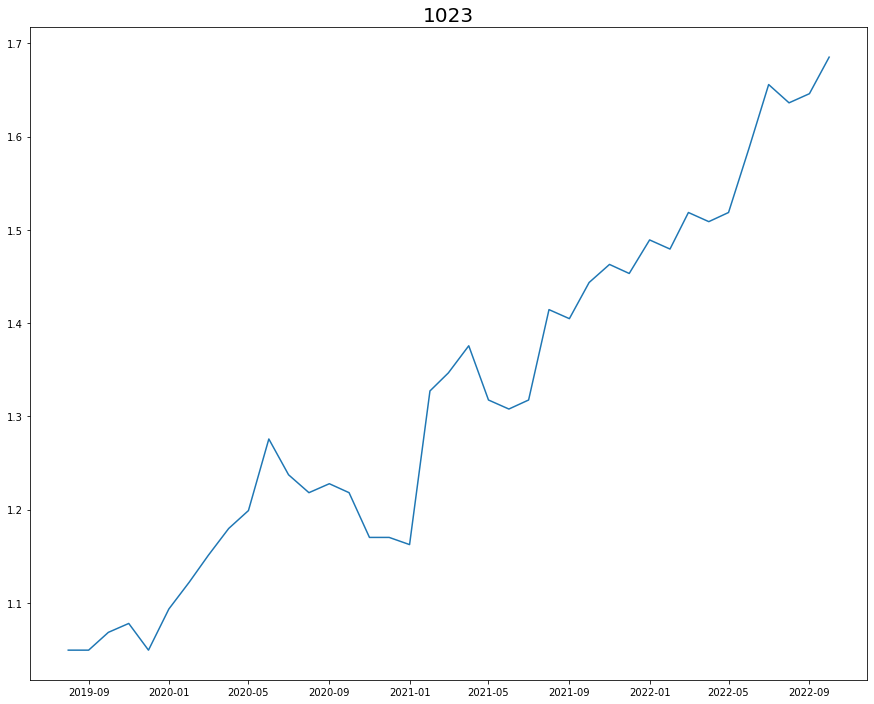

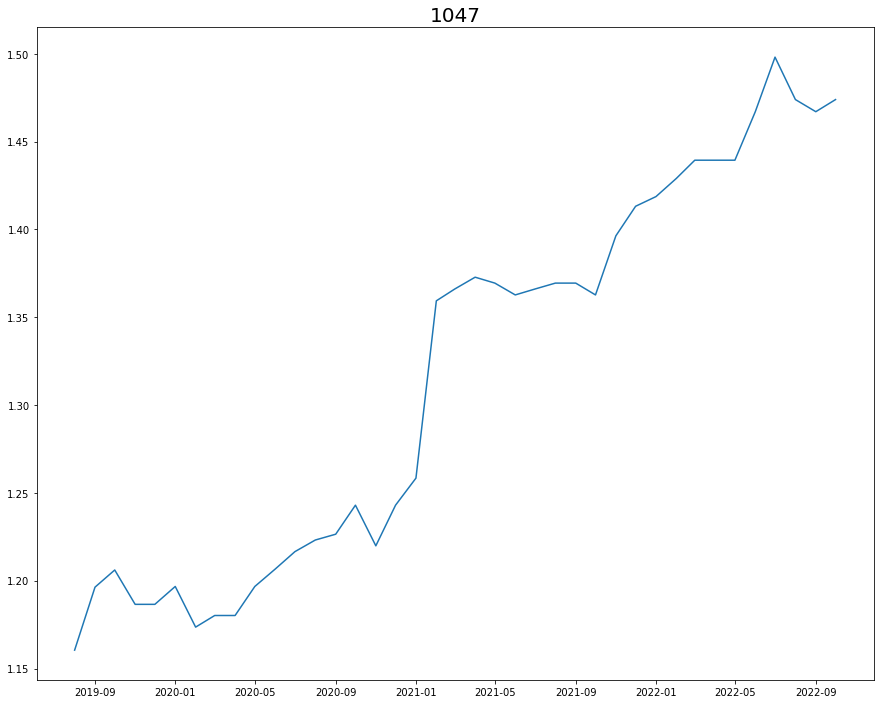

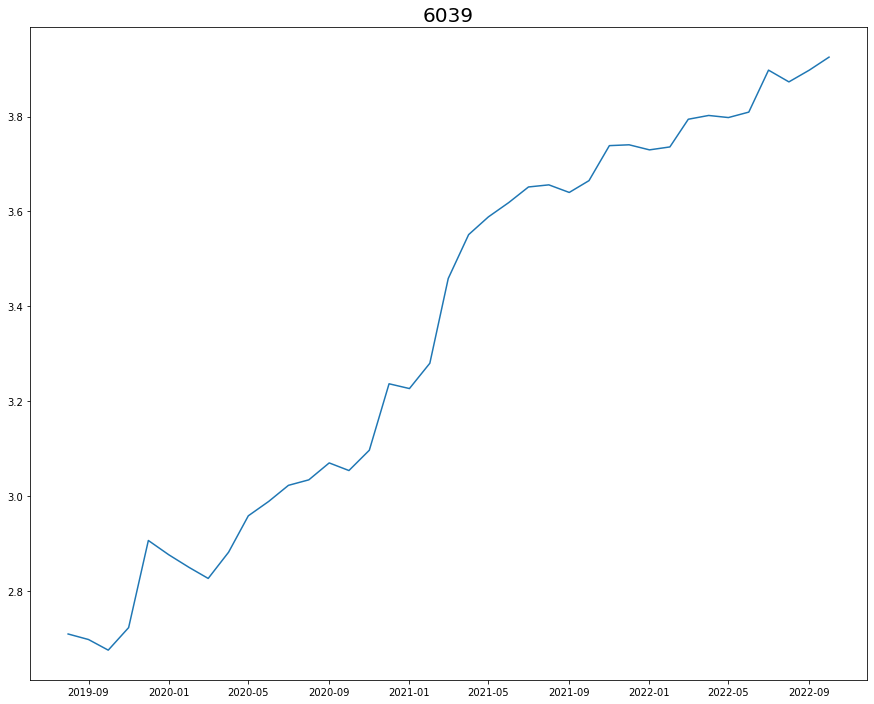

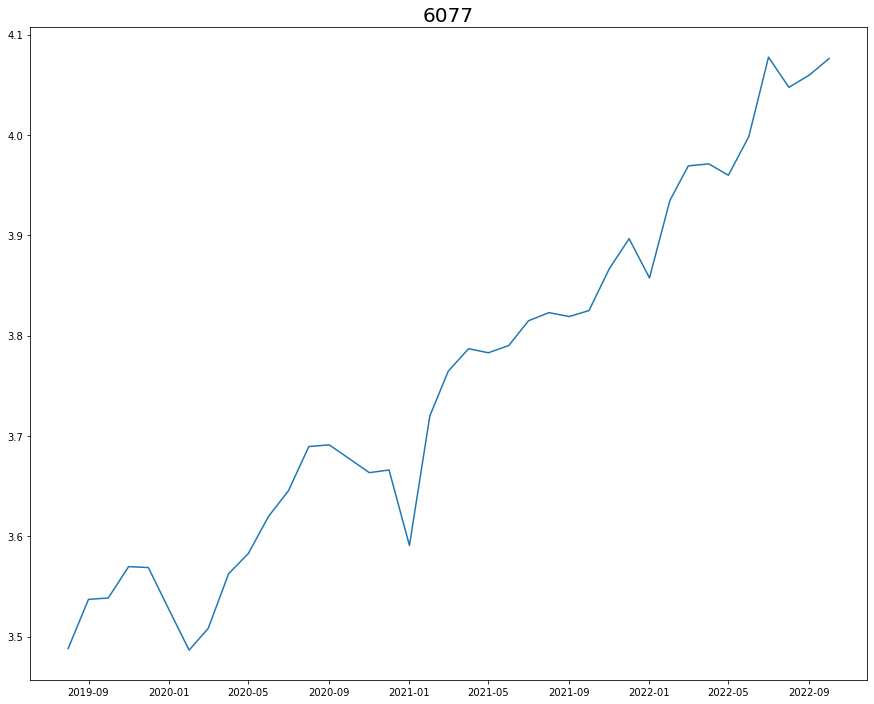

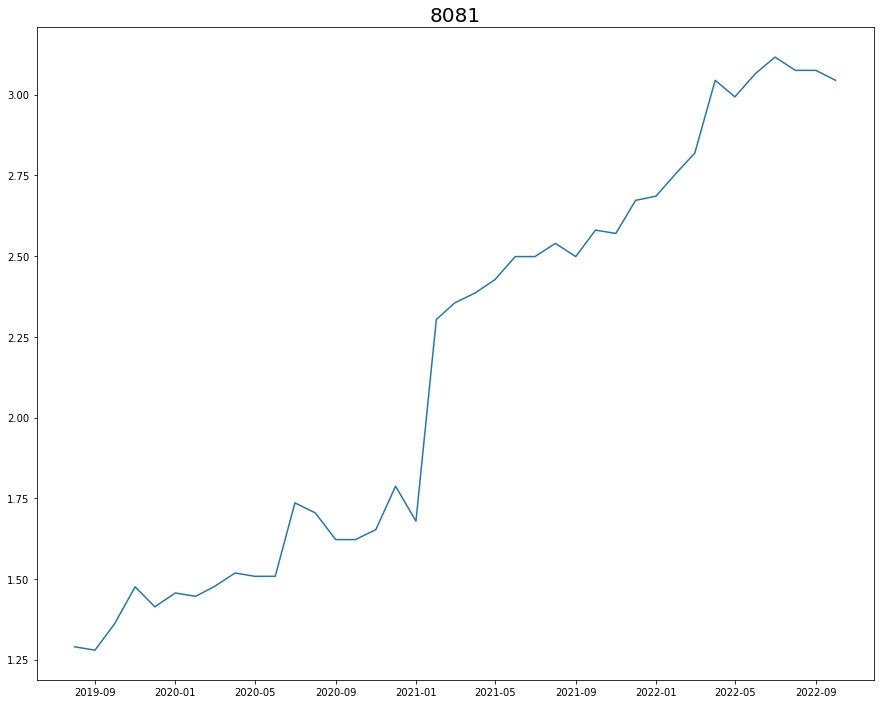

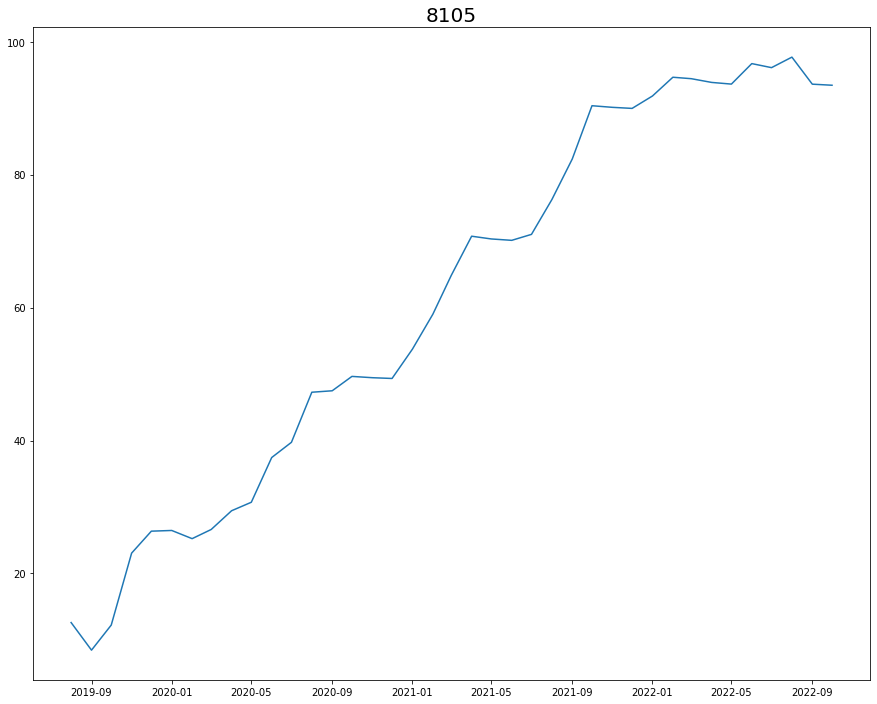

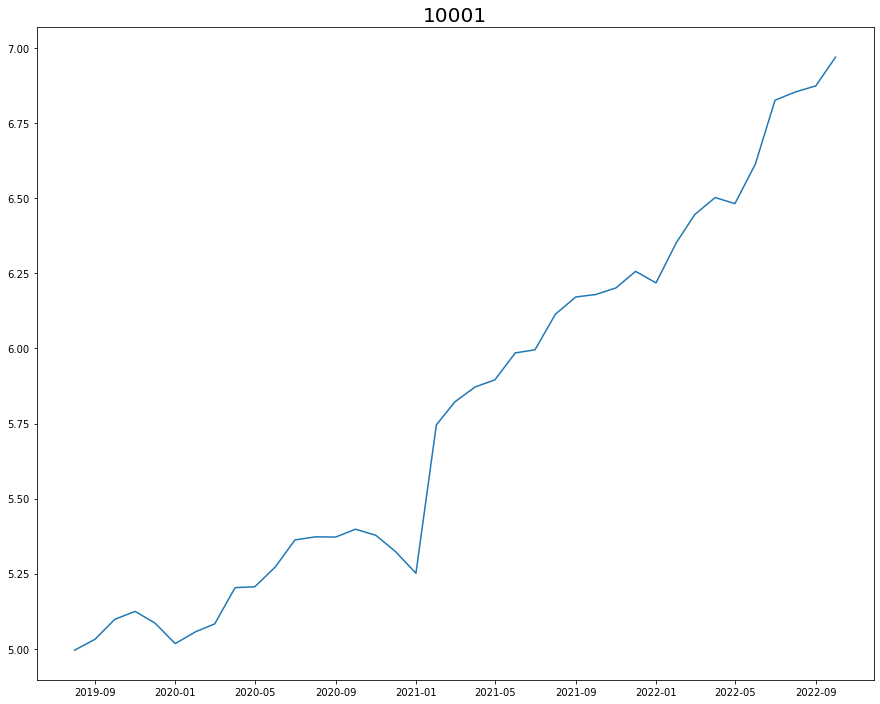

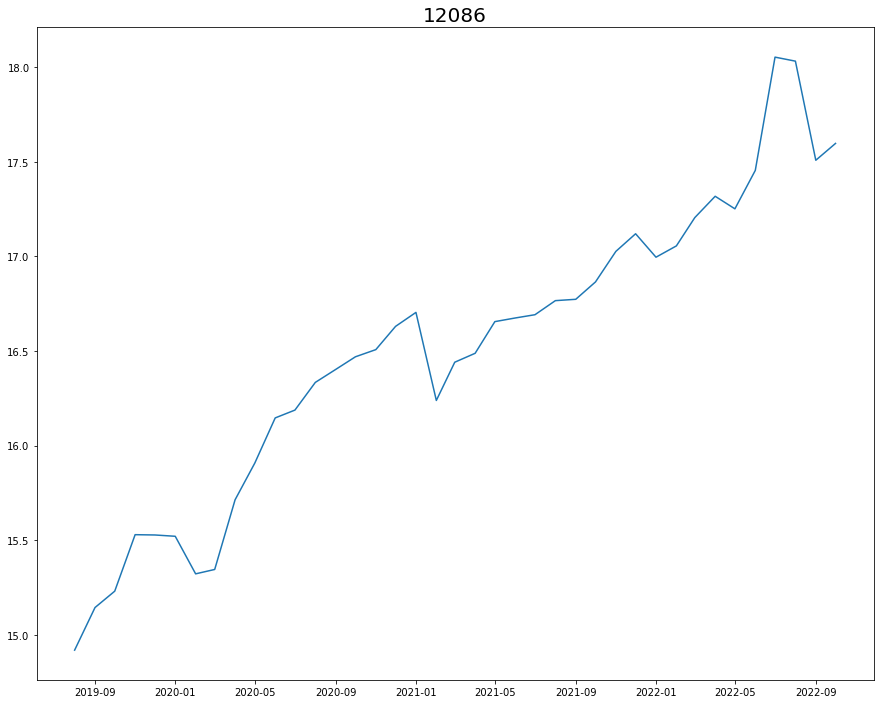

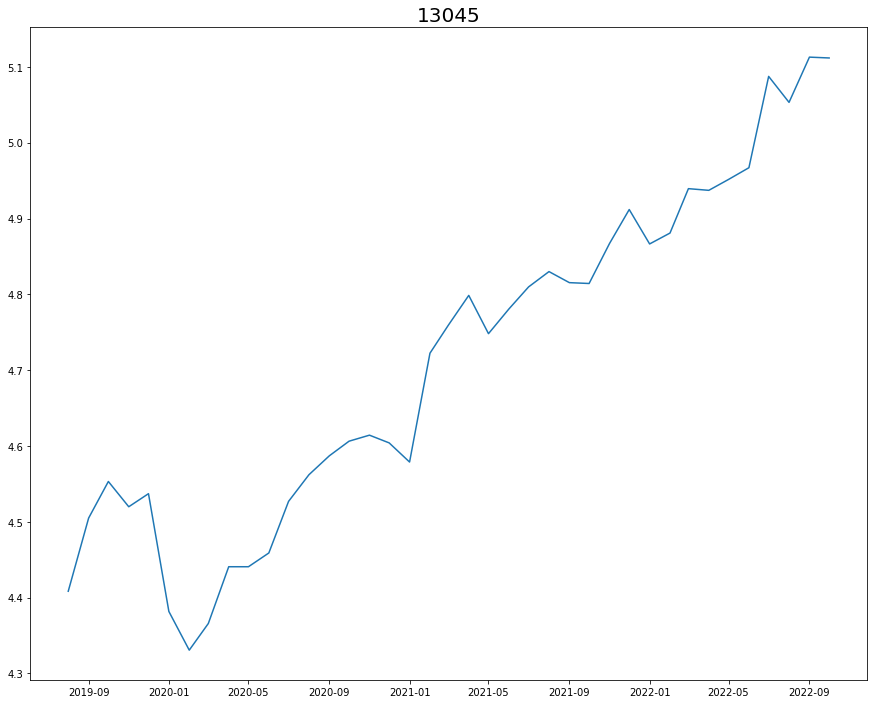

In [12]:
for i in cfips_lin[0:10]:
    plt.subplots(figsize=(15,12))
    data=train[train.cfips==i]
    plt.plot(data.first_day_of_month,data.microbusiness_density)
    plt.title(i,fontsize=20)

In [ ]:
cfips_high_err

In [ ]:
for i in cfips_high_err:
    plt.subplots(figsize=(15,12))
    data=train[train.cfips==i]
    plt.plot(data.first_day_of_month,data.microbusiness_density)
    plt.title(i,fontsize=20)

# Write Submission CSV

In [34]:
# THRESHOLD =0.103  #this is 10.3% same value as 8/78 from old notebook
# ACTIVE_THRESHOLD =25_000

# unique_cfips =train.cfips.unique() # return unique cflips
# x_train =np.arange(36).reshape((-1,1))# return (36,1) x_train arrays 
# x_test =np.arange(38,47).reshape((-1,1)) # return (8,1) x_test array
# x_val=np.arange(36,39).reshape((-1,1))
# preds = np.zeros((len(unique_cfips),8),dtype='float')

# last_preds = np.zeros((len(unique_cfips),8),dtype='float')
# lin_trend = 0

# R2_score=[]
# cfips_bad_r2score=[]
# cfips_poor_pred=[]
# s_list=[]
# for i,c in enumerate(unique_cfips):
#     df=train.loc[train.cfips==c] # generate data frame for the selected cfips
#     last=df.microbusiness_density.values[-4:-1].mean() # store the mean of last value ( OCT-01,22) as last
    
#     # FIT LINEAR REGRESSION
#     model = LinearRegression()
#     model.fit(x_train,df.microbusiness_density) # fit a linear model
#     p =model.predict(x_train) # predict  
#     R2_score.append(r2_score(p,df.microbusiness_density))
#     # COMPUTE TRAIN ERROR
#     err =p-df.microbusiness_density.values
#     rng = df.microbusiness_density.max()-df.microbusiness_density.min()
    
#     # DETERMIN IF TIME SERIES IS LINEAR OR NOT
#     # create a list of error
#     s=0
#     for k in range(39): # for each month in the training set we will run the function
#         e=np.abs(err[k]) # returns absolute error 
#         r=e/rng #error divided by the actual value
#         s+=r
#     s=s/36 # now S is MAPE mean absolute percentage error
#     # If s is less than 10% then we can assume the county follows linear trend
#        # INFER TEST DATA WITH LINEAR REGRESSION
#     if s>0.103:
#         preds[i,] = [last]*8
#         continue 
#     p2 = model.predict(x_test)
#     shift=last-p2[0]
#     preds[i,]=p2[1:]+shift 
#     #print the cfips with bad r2_score
    

In [35]:
# test['microbusiness_density']=preds.reshape((-1))
# sub = test[['row_id','microbusiness_density']]
# sub.to_csv('submission_cleaned.csv',index=False)
# print( sub.shape )
# sub.head()

In [36]:
train.groupby(['first_day_of_month','cfips','row_id'])['microbusiness_density'].mean().reset_index().sort_values('cfips')

,first_day_of_month,cfips,row_id,microbusiness_density
0,2019-08-01,1001,1001_2019-08-01,3.007682
37620,2020-08-01,1001,1001_2020-08-01,3.174679
109725,2022-07-01,1001,1001_2022-07-01,3.437971
112860,2022-08-01,1001,1001_2022-08-01,3.423852
50160,2020-12-01,1001,1001_2020-12-01,3.002558
...,...,...,...,...
94049,2022-01-01,56045,56045_2022-01-01,1.749688
84644,2021-10-01,56045,56045_2021-10-01,1.670559
37619,2020-07-01,56045,56045_2020-07-01,1.554960
106589,2022-05-01,56045,56045_2022-05-01,1.803249


In [37]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


## train-validate split

In [38]:
df=train.copy()
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [39]:
x_train=np.arange(36).reshape(-1,1)
x_val=np.arange(36,39).reshape(-1,1)
val_preds=np.zeros((len(unique_cfips),3),dtype='float')

# Lag features

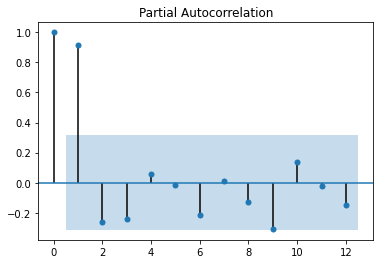

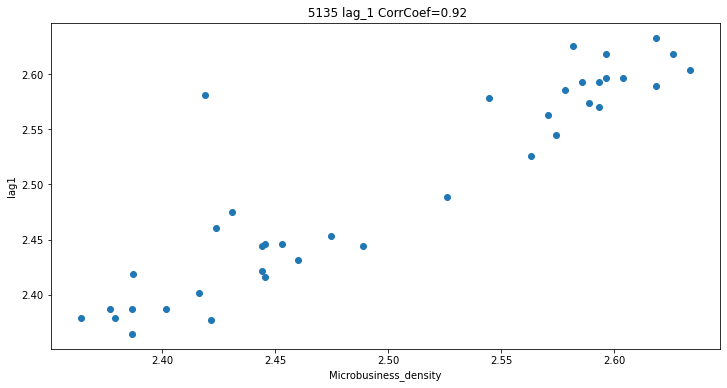

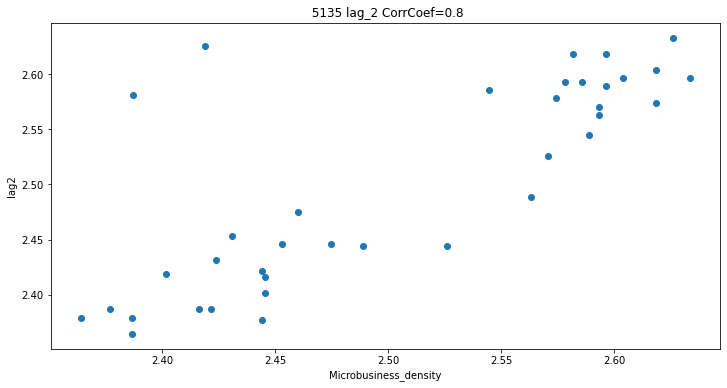

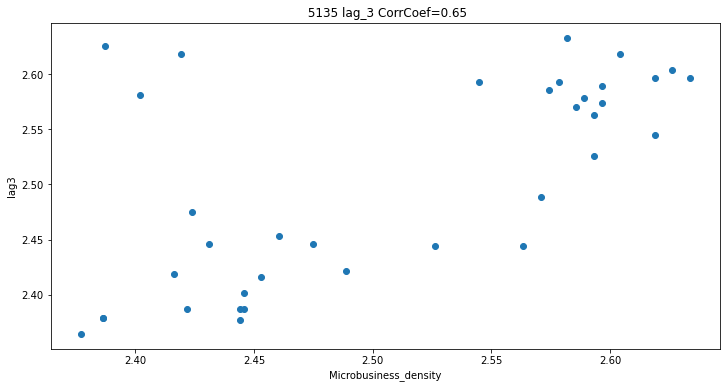

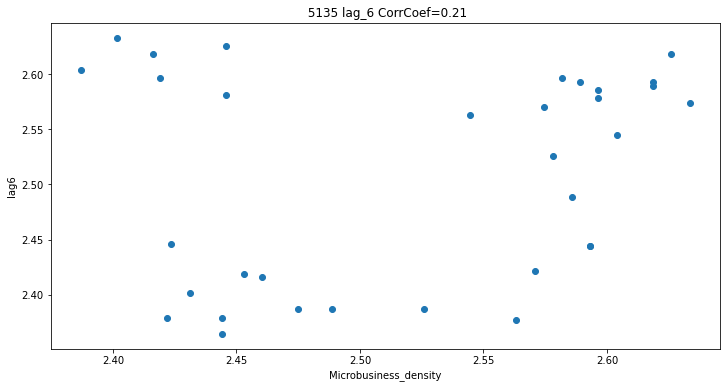

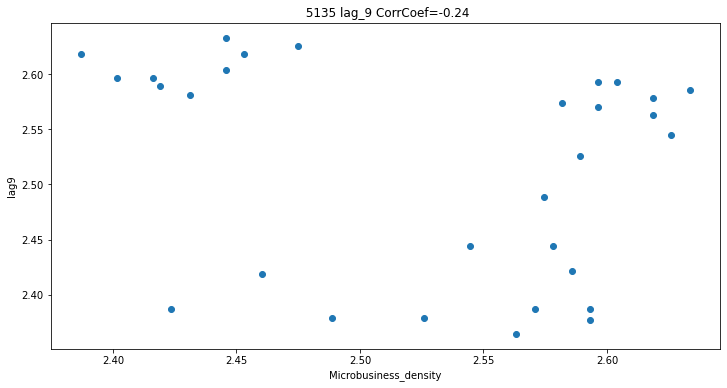

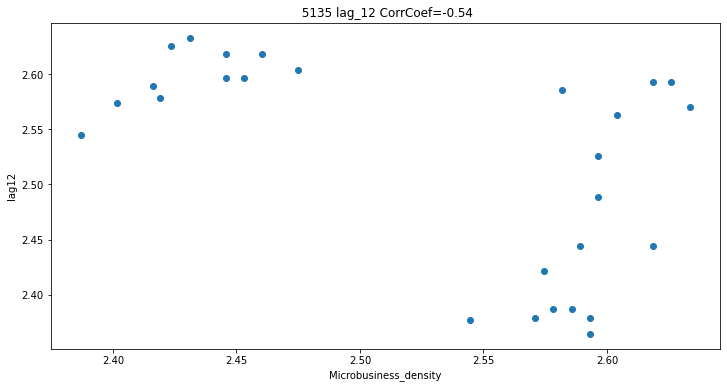

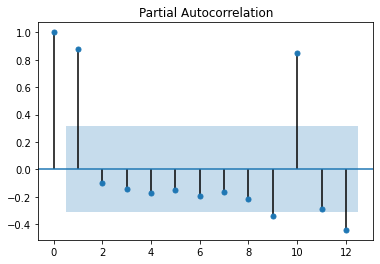

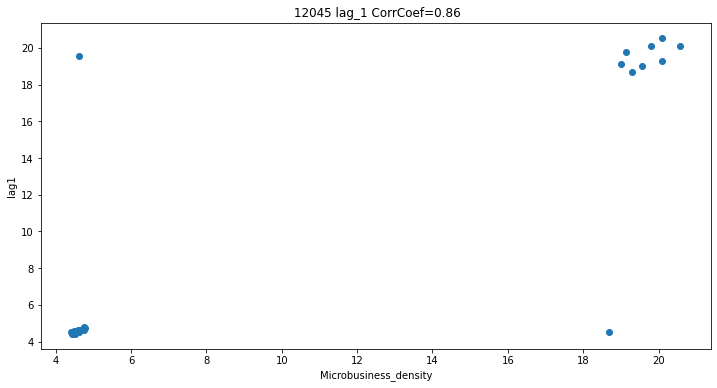

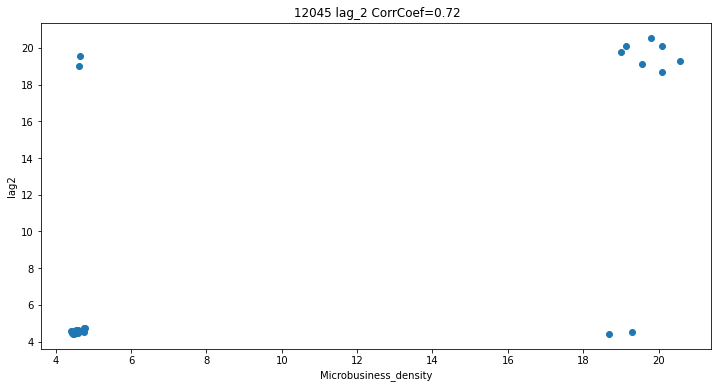

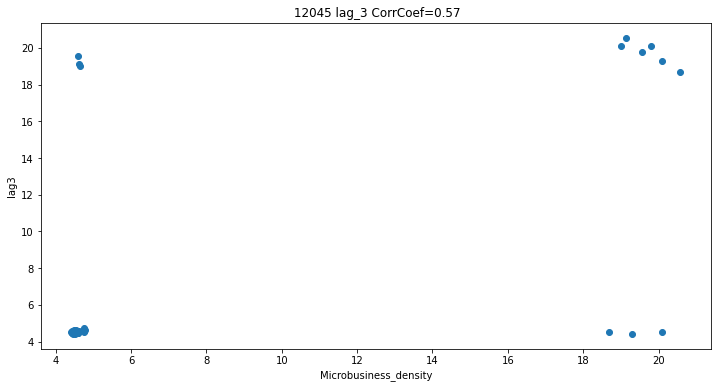

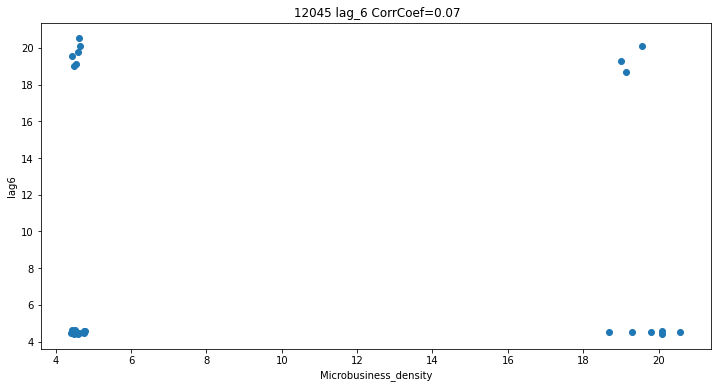

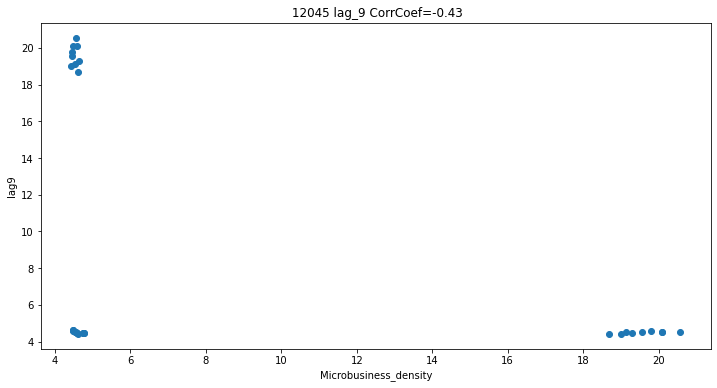

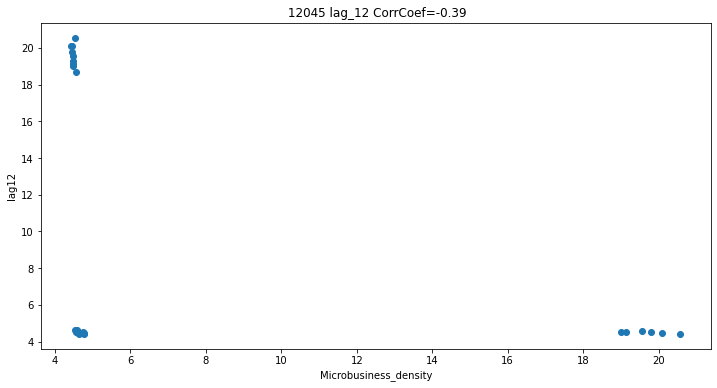

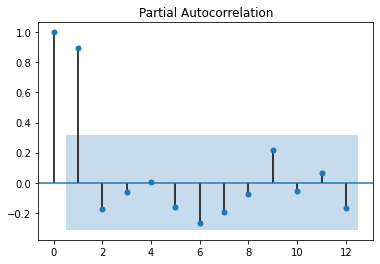

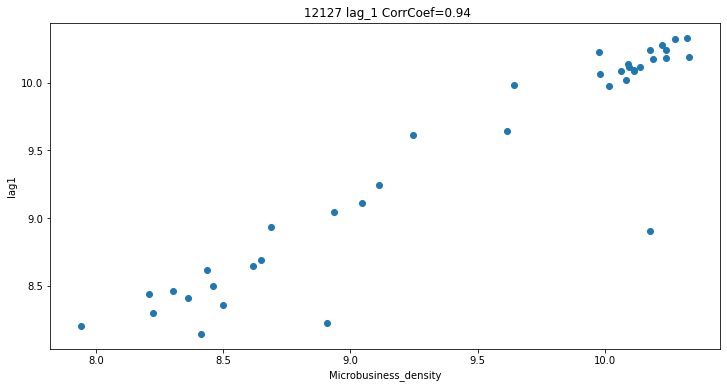

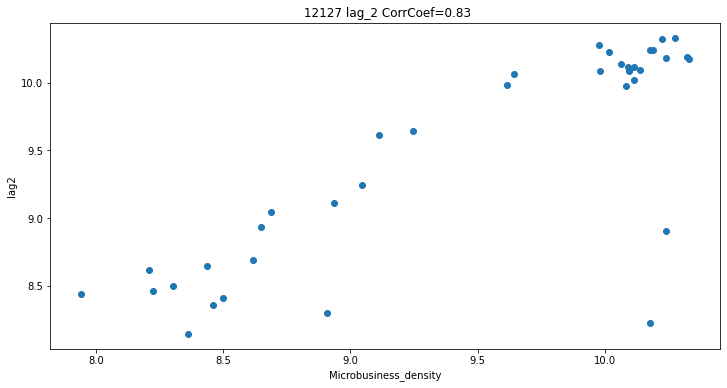

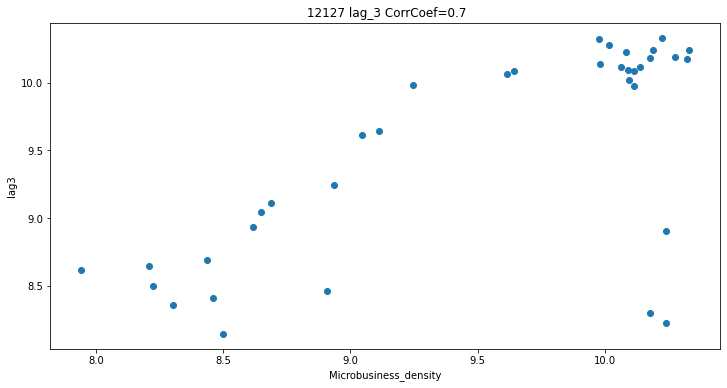

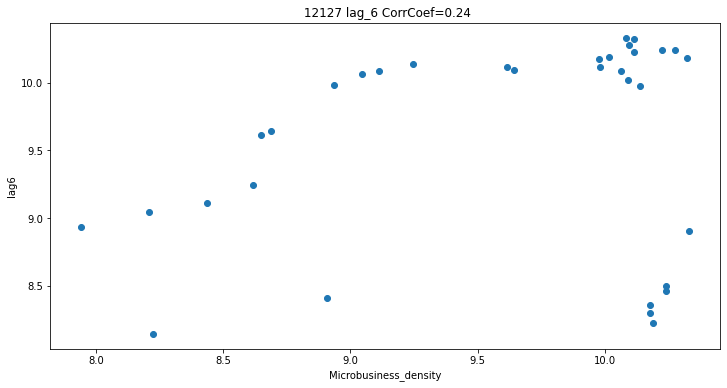

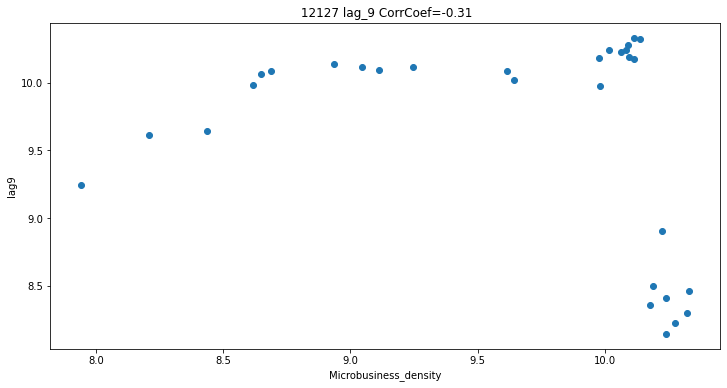

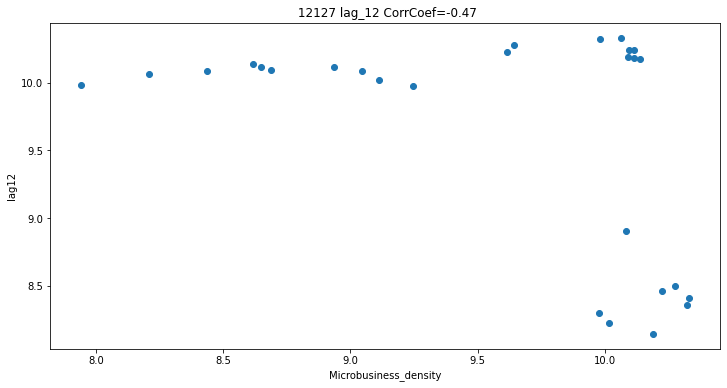

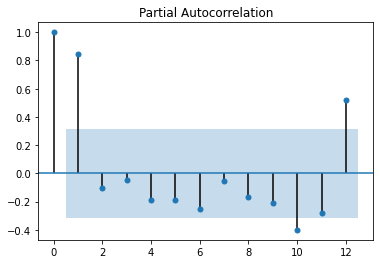

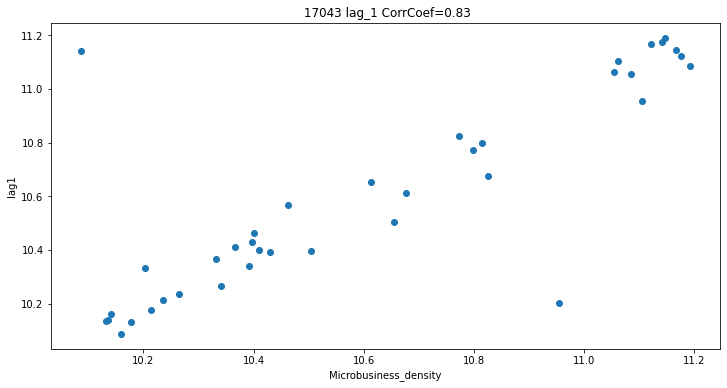

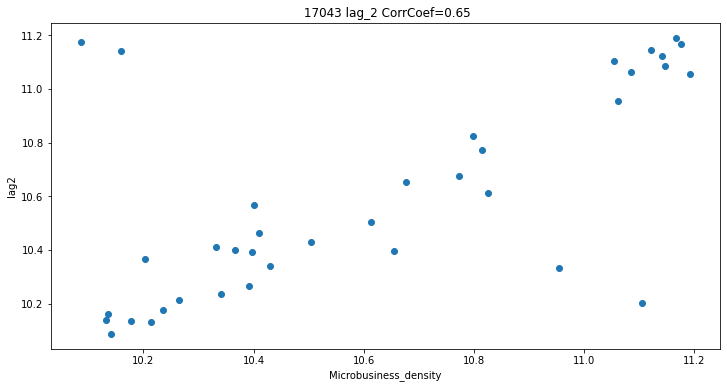

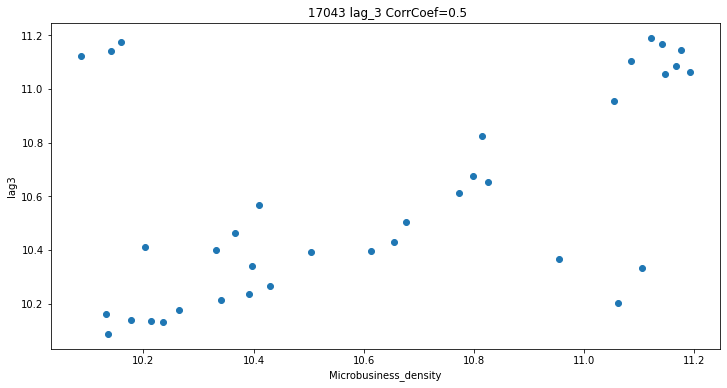

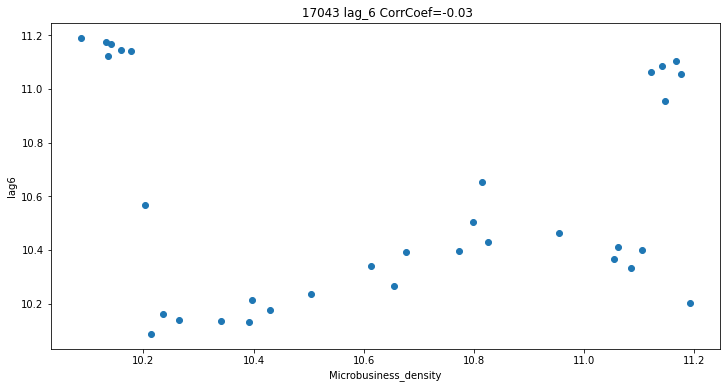

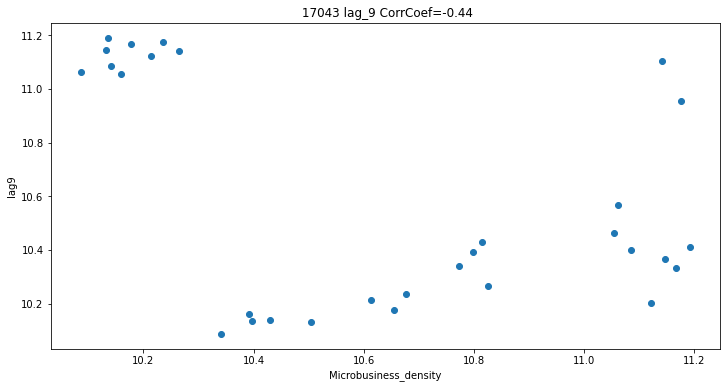

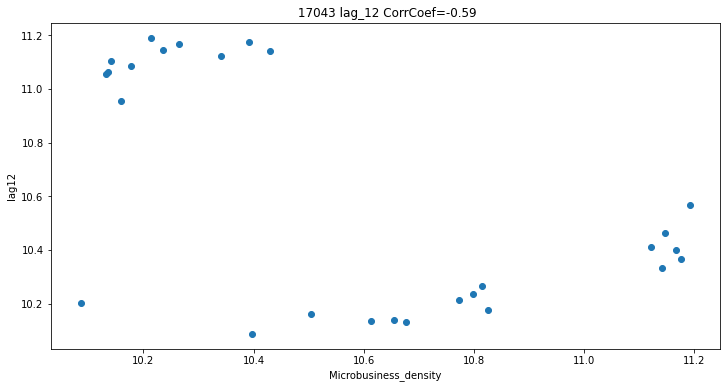

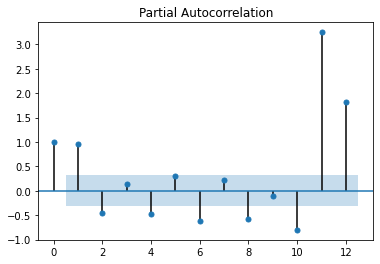

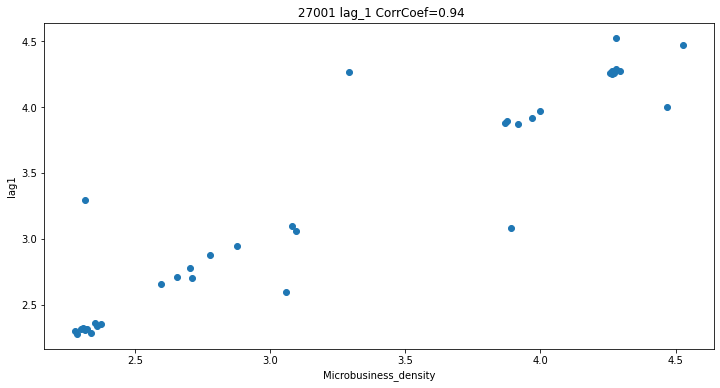

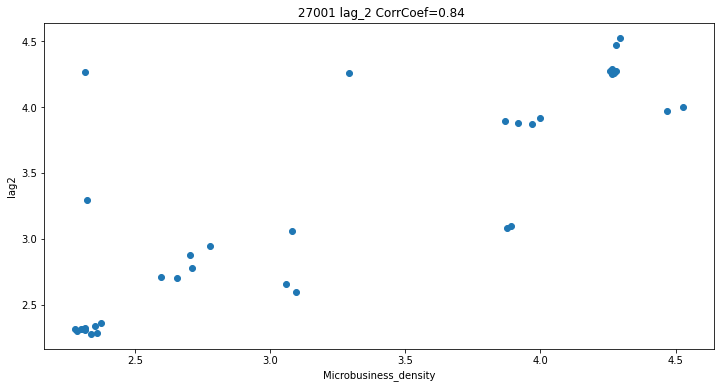

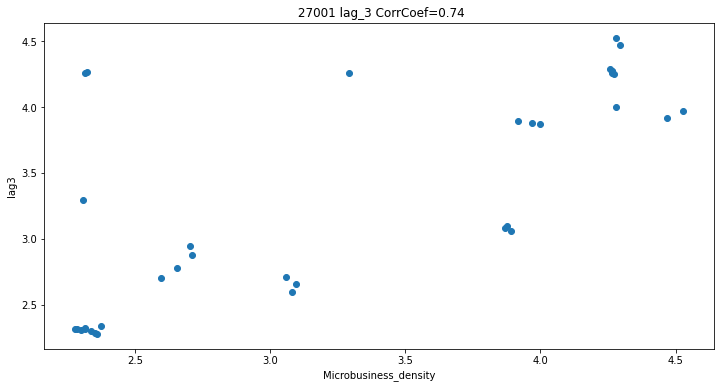

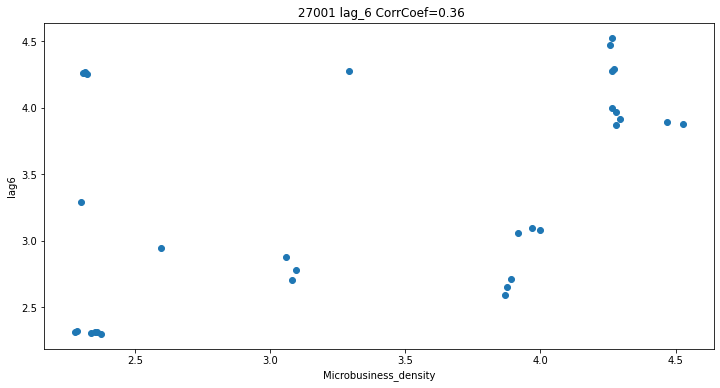

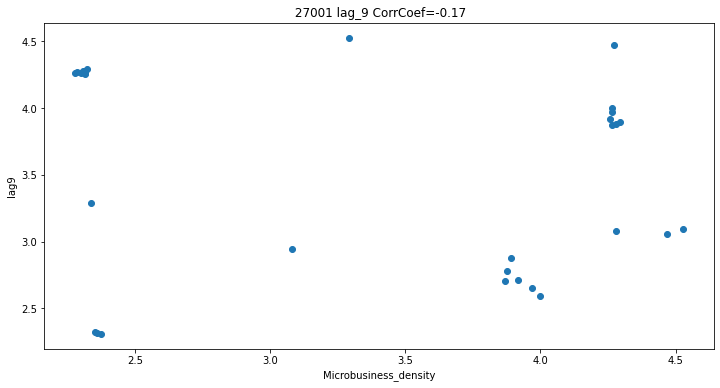

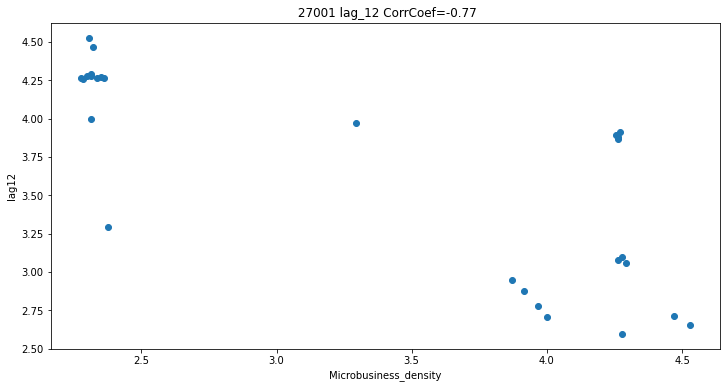

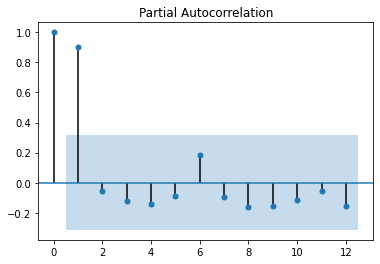

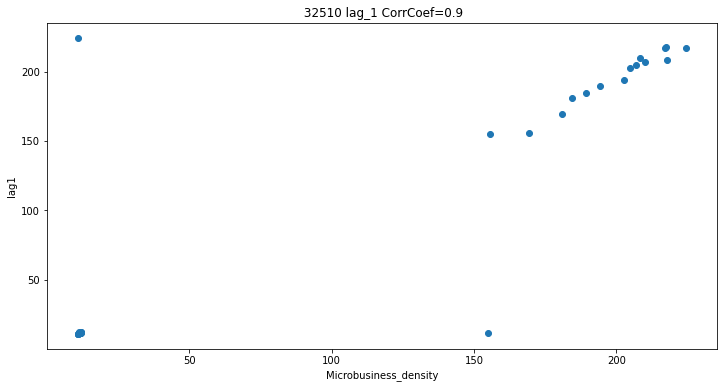

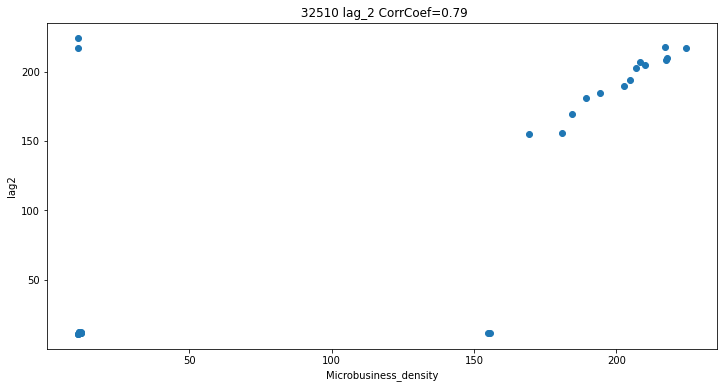

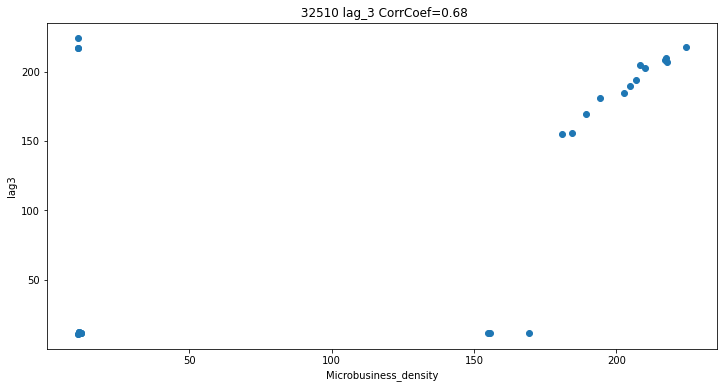

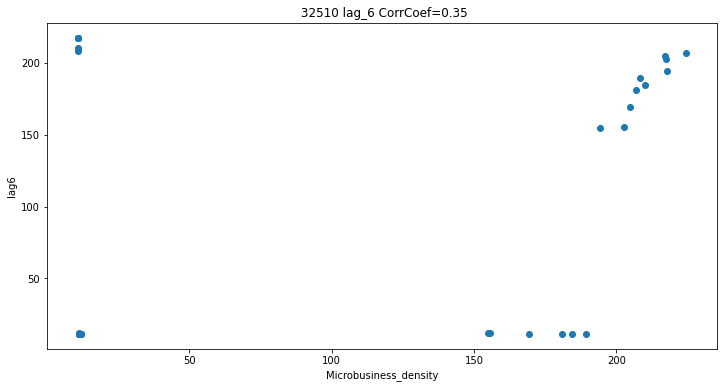

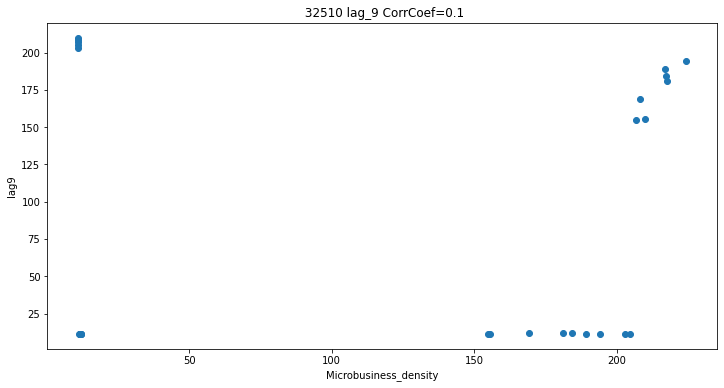

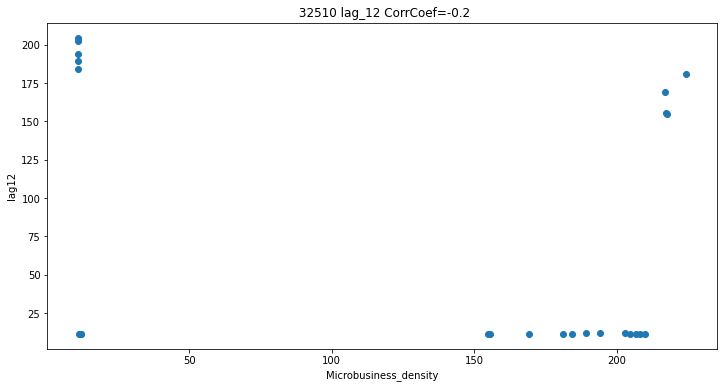

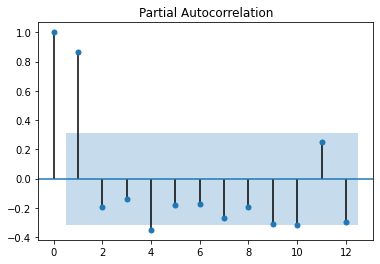

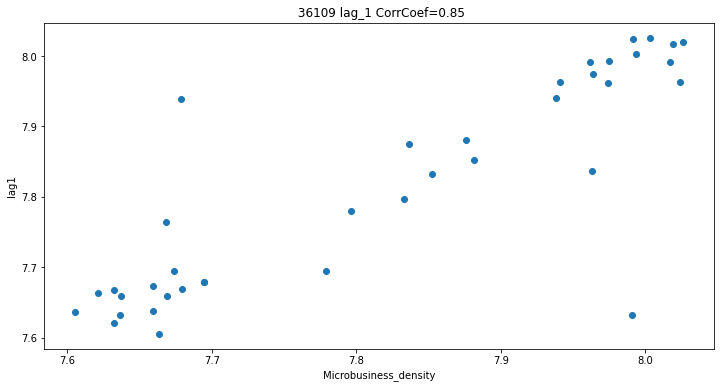

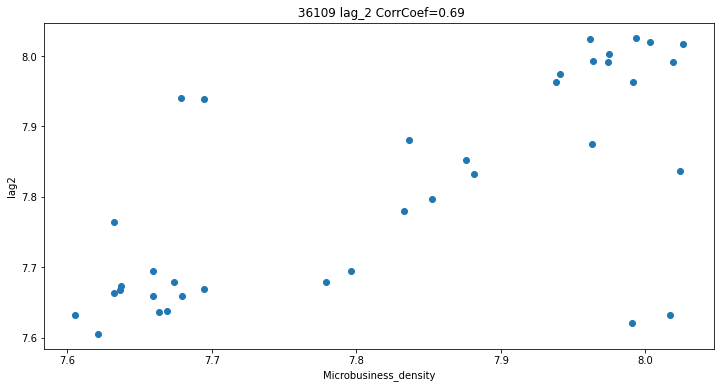

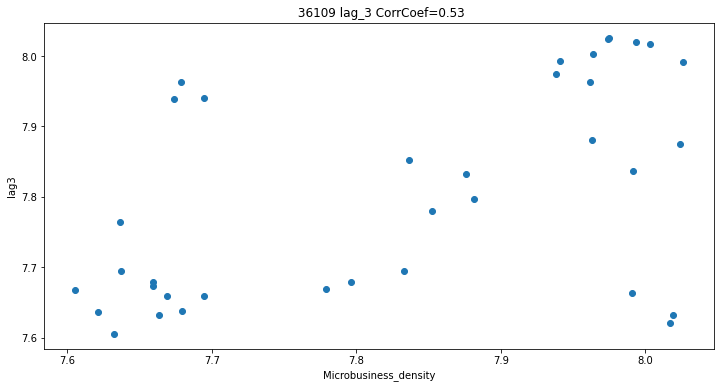

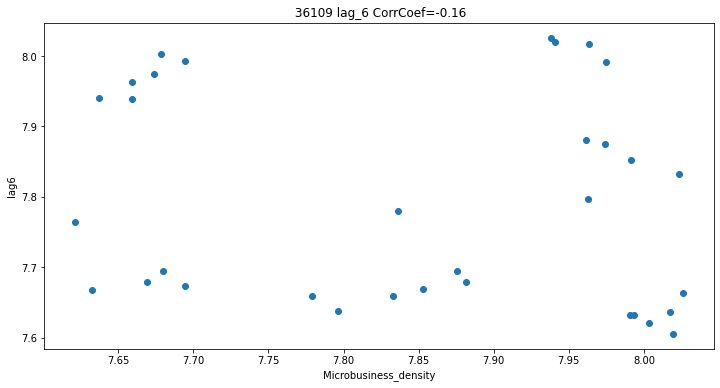

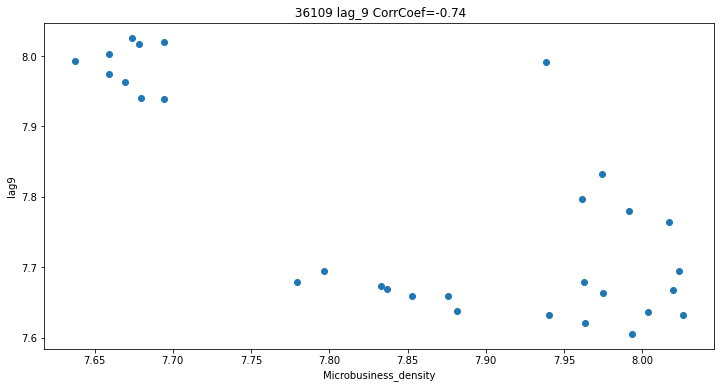

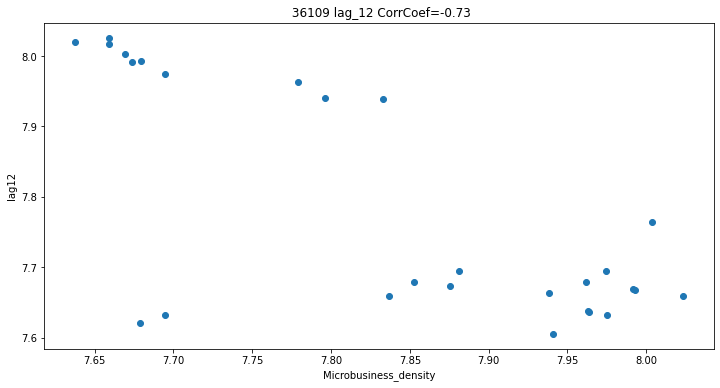

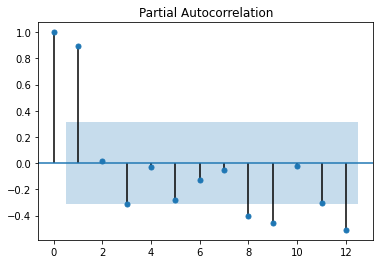

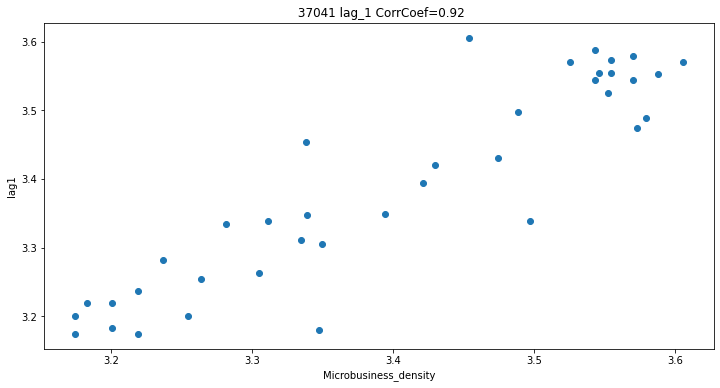

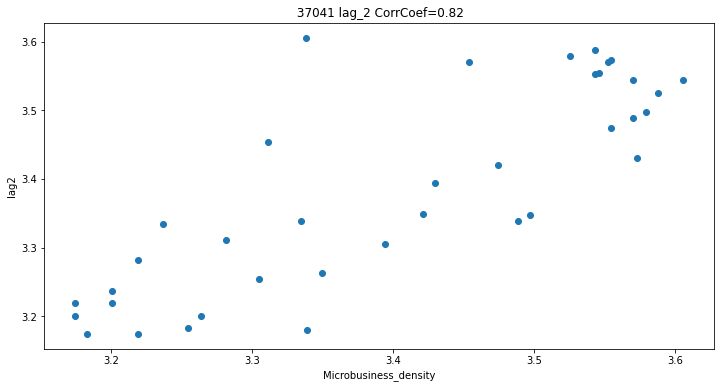

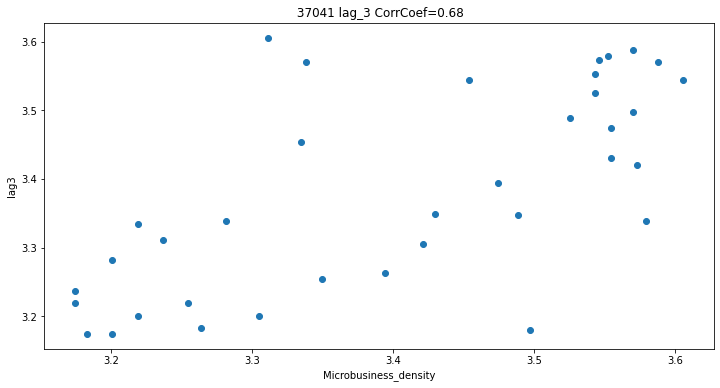

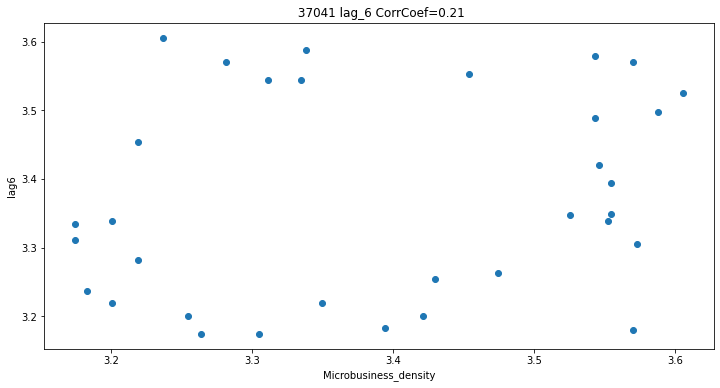

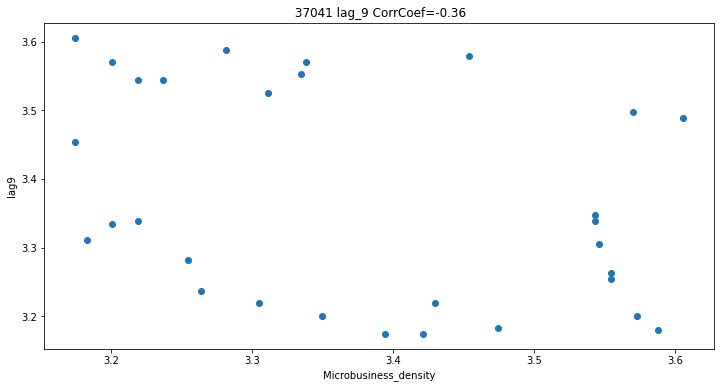

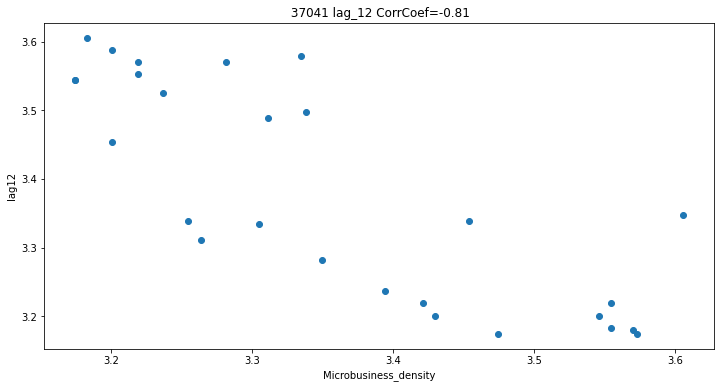

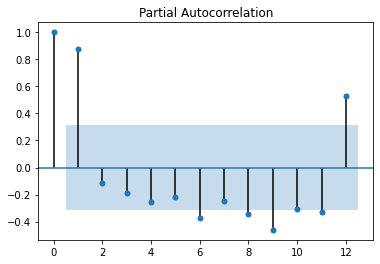

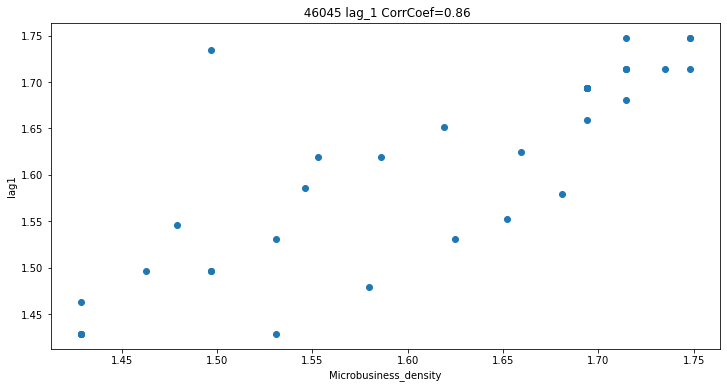

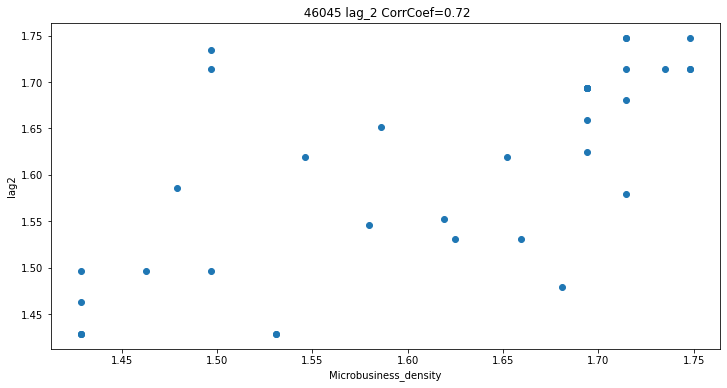

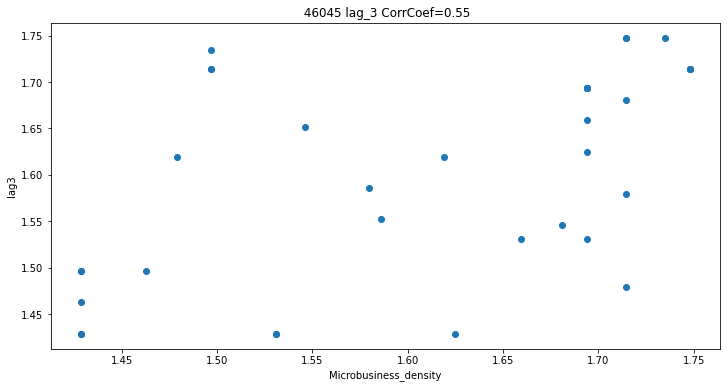

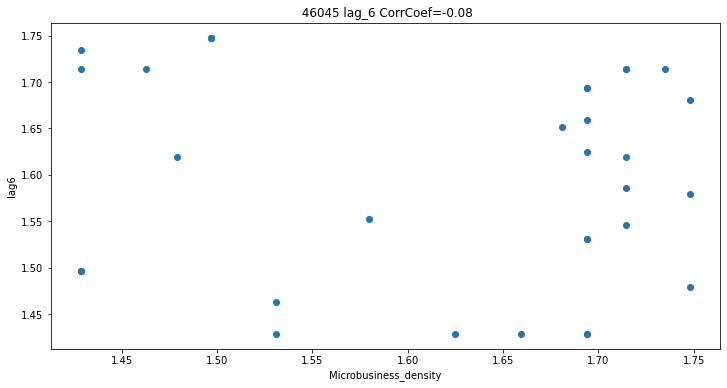

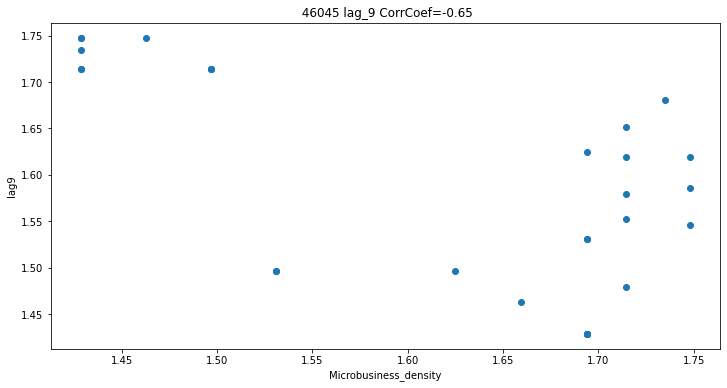

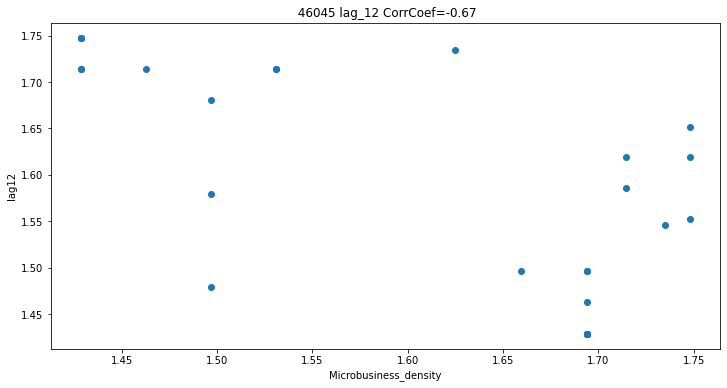

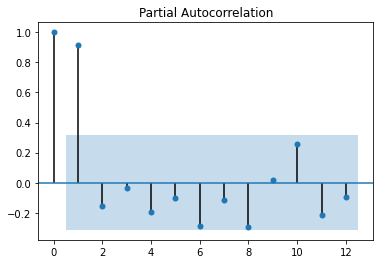

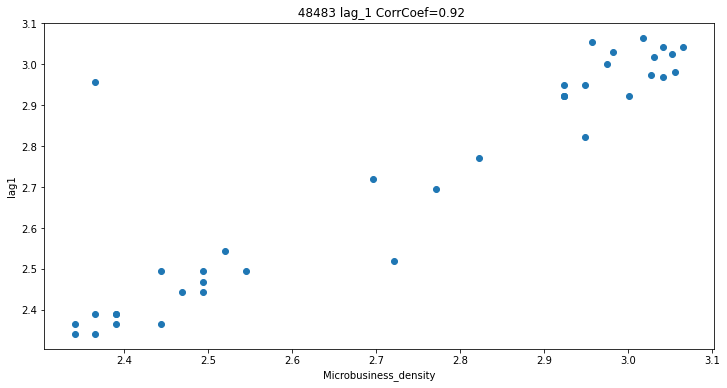

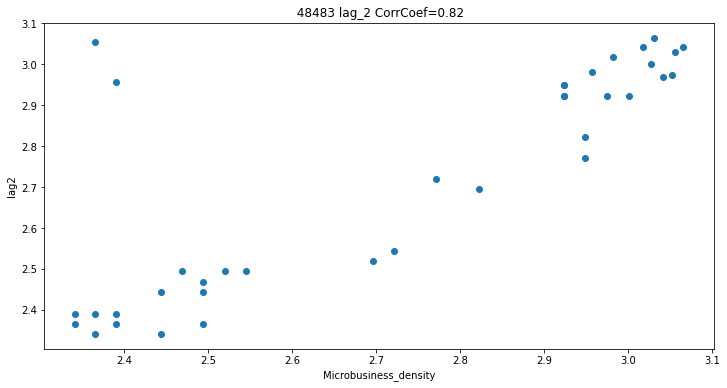

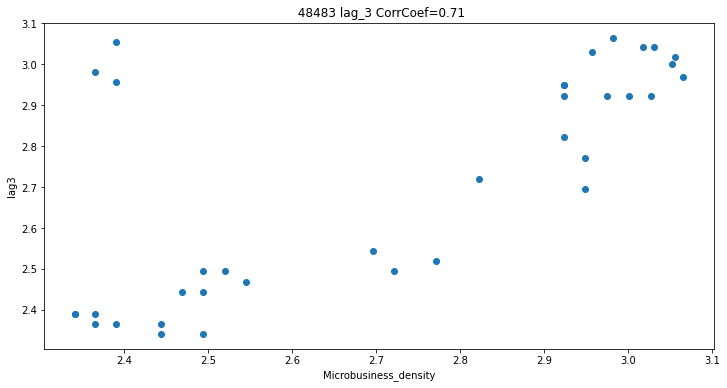

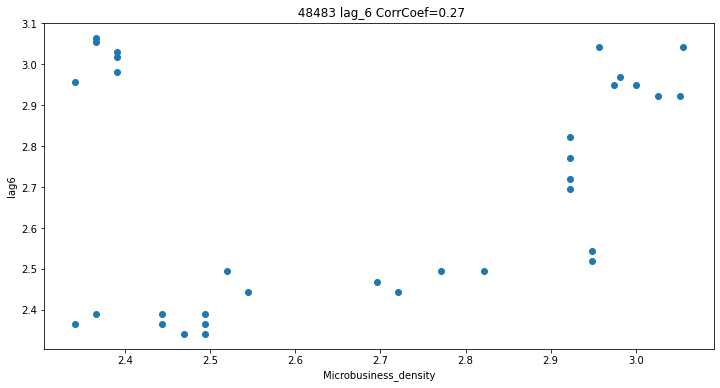

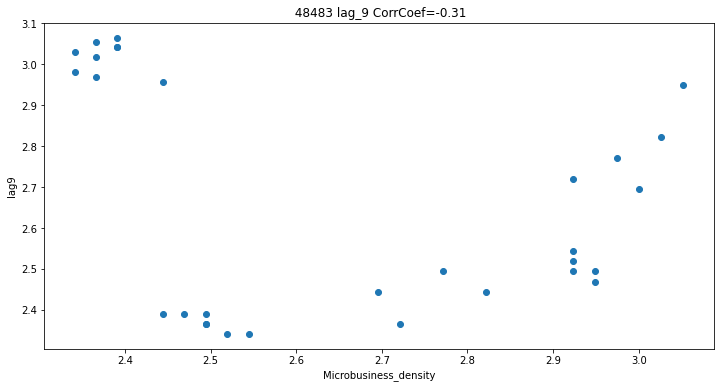

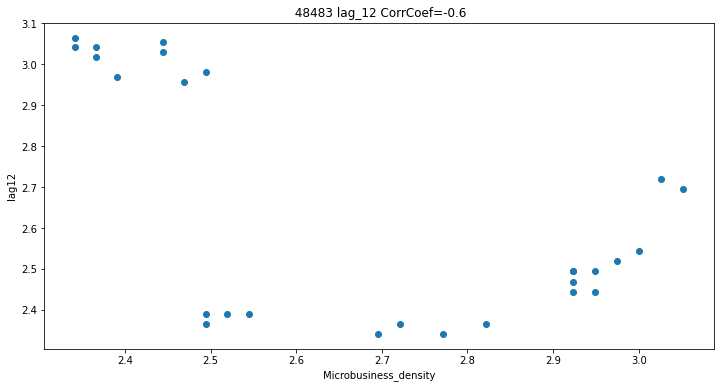

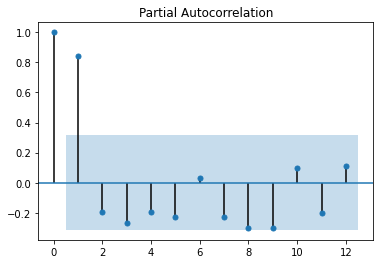

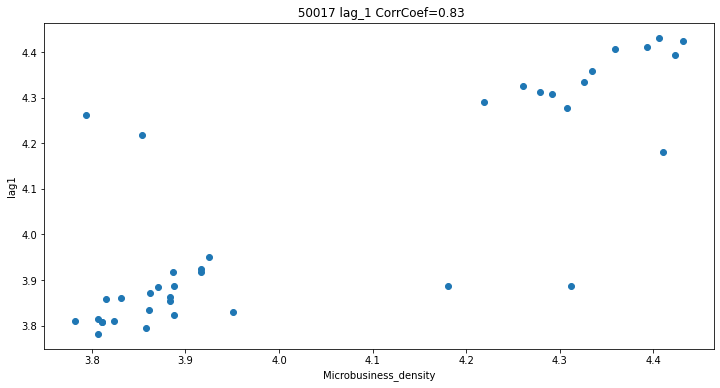

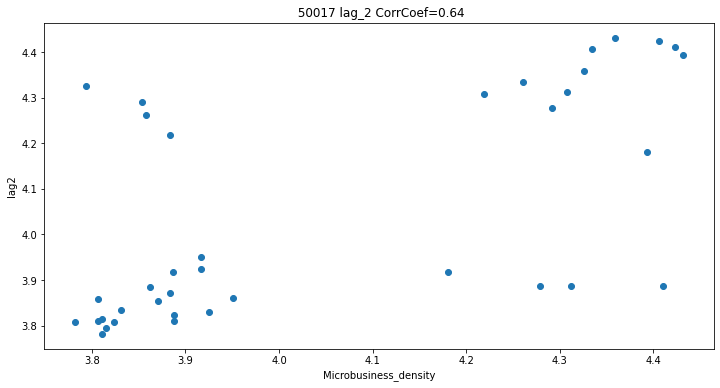

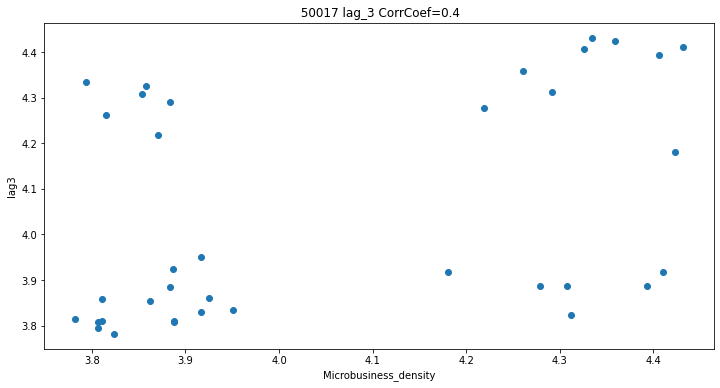

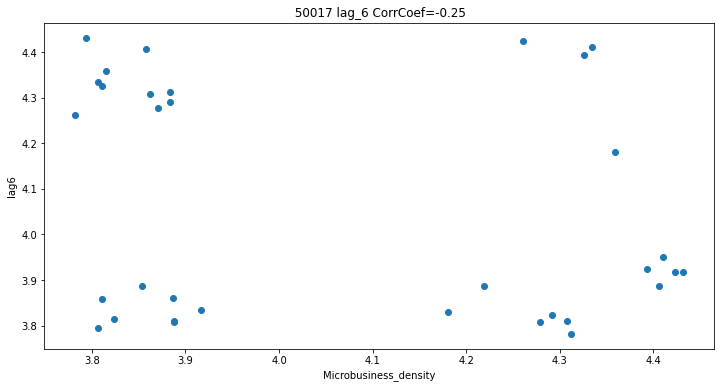

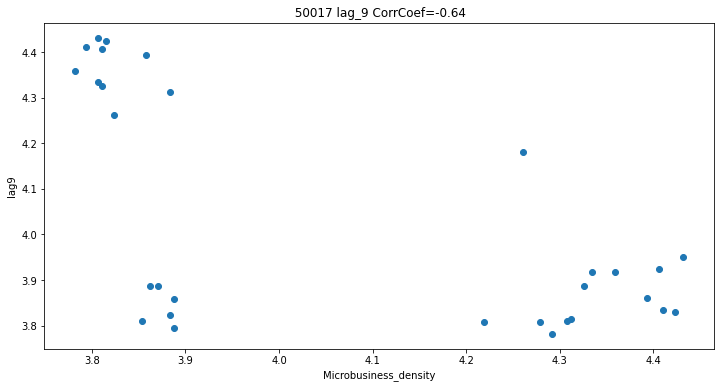

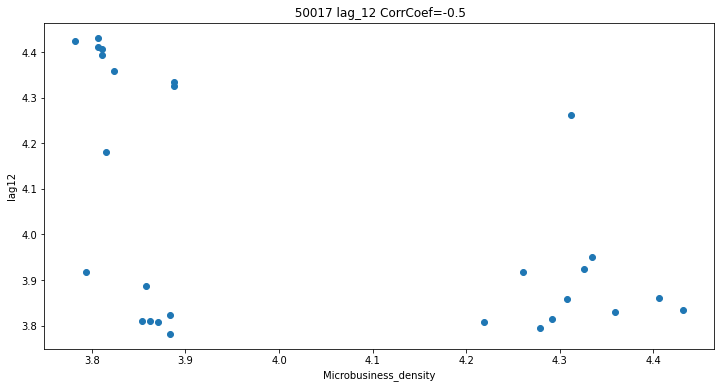

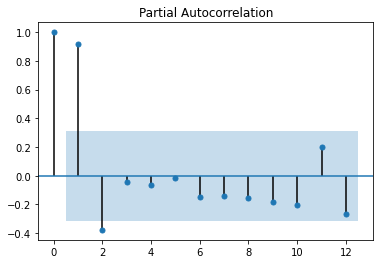

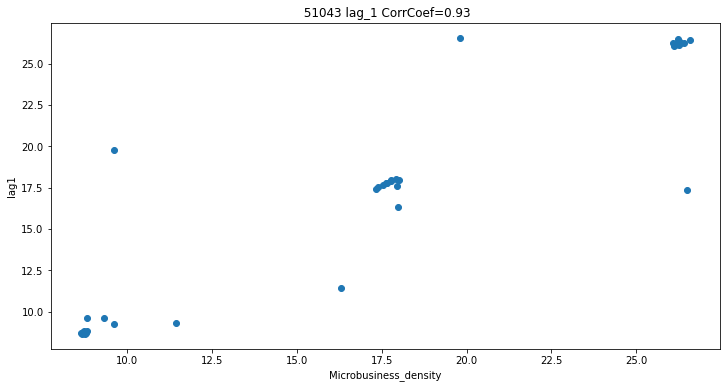

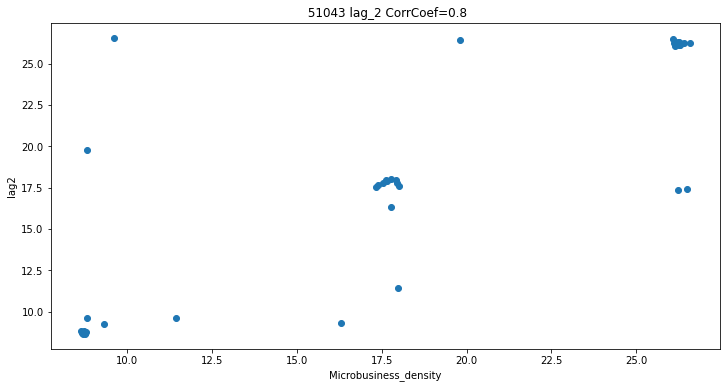

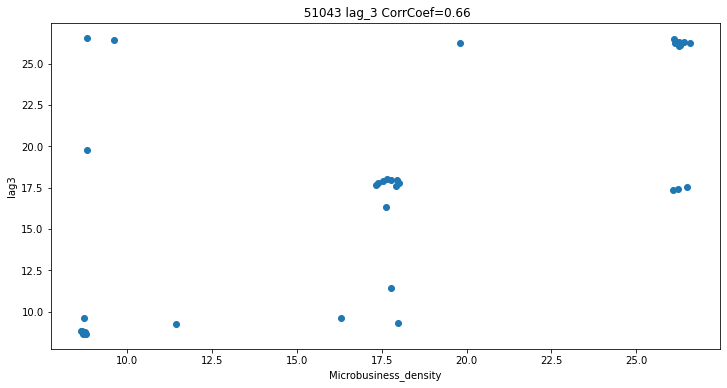

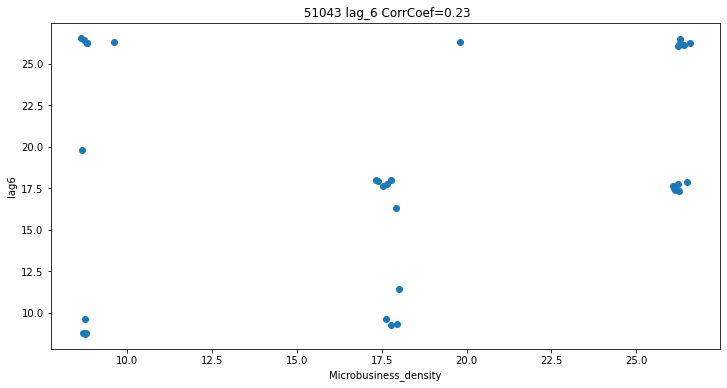

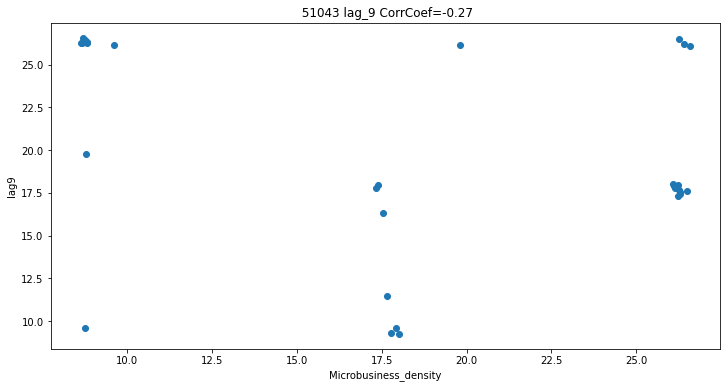

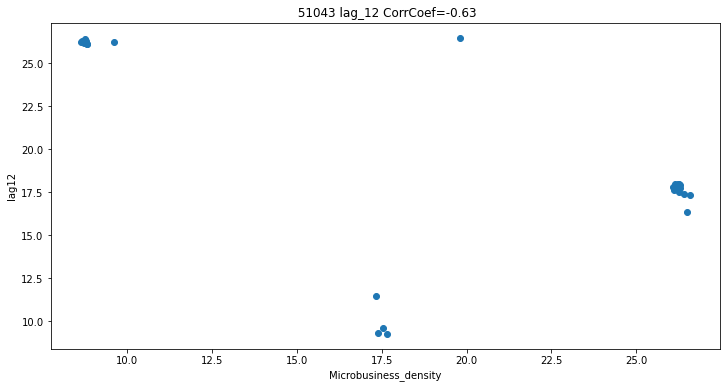

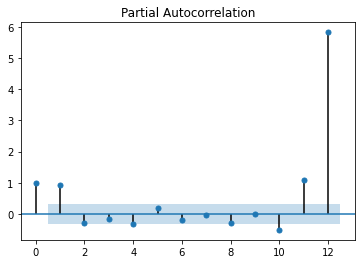

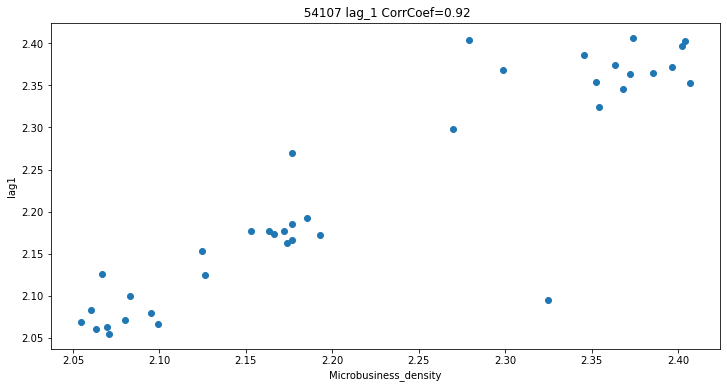

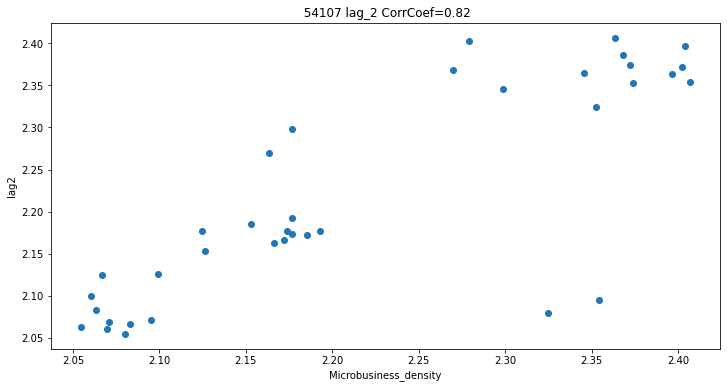

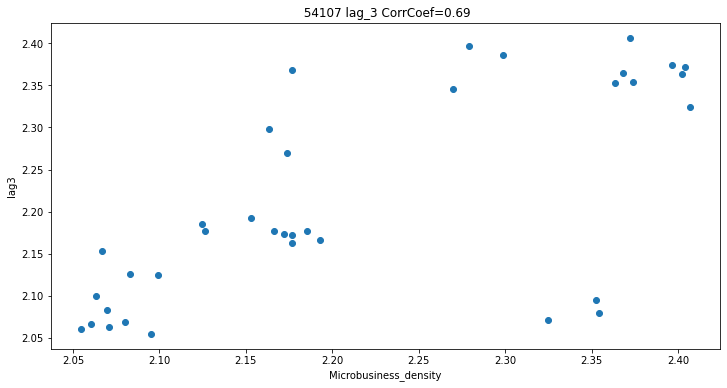

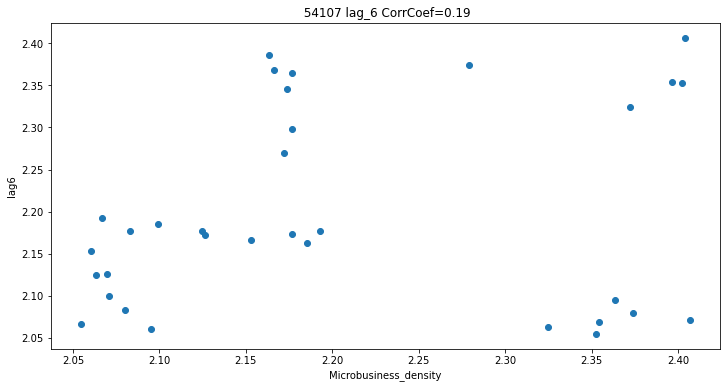

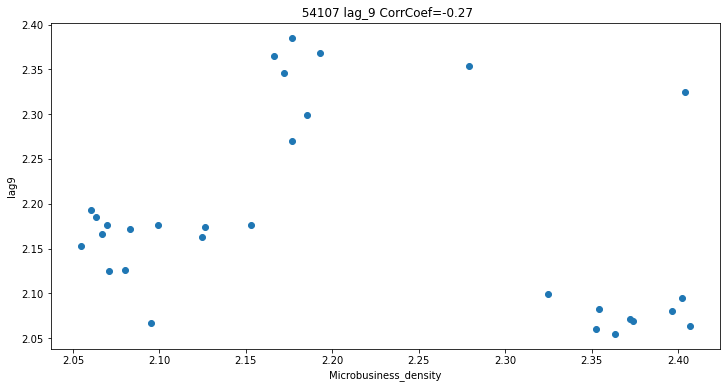

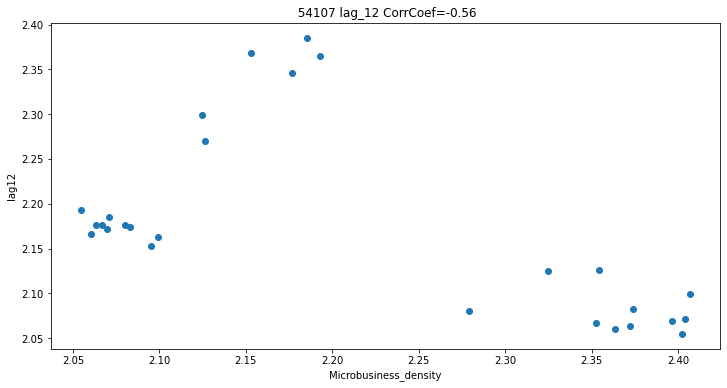

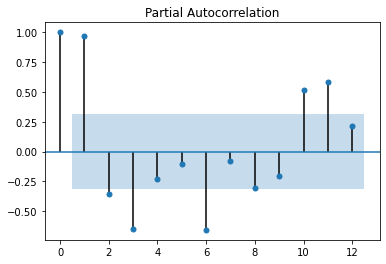

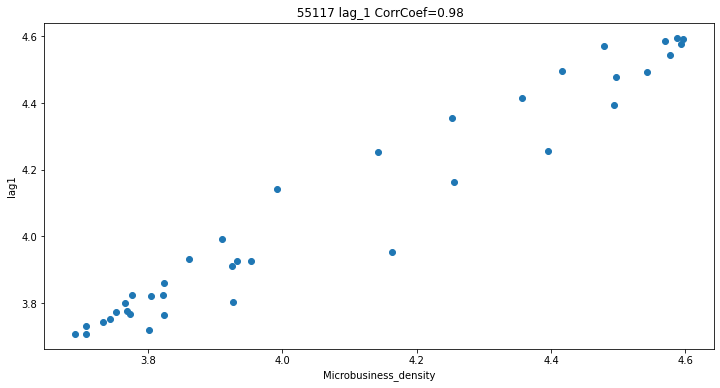

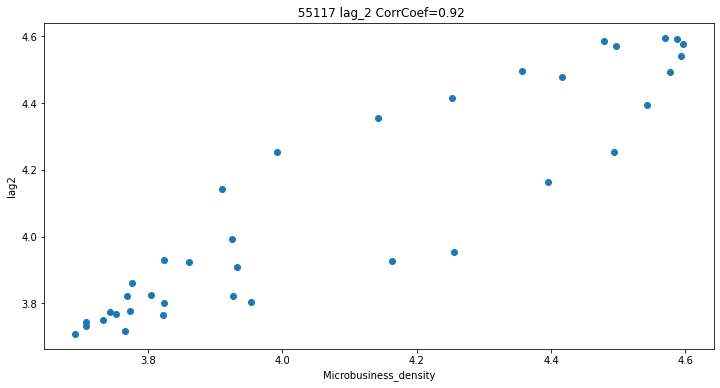

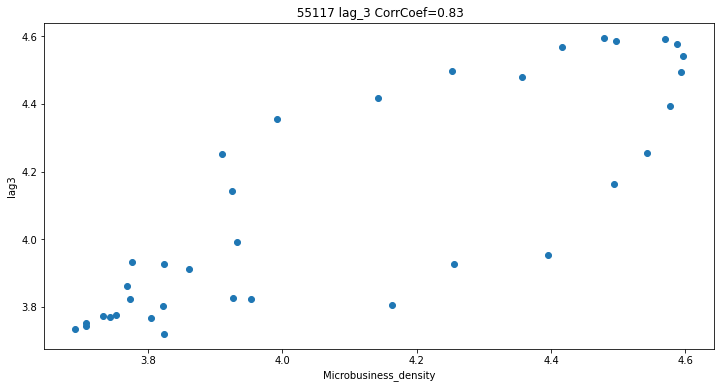

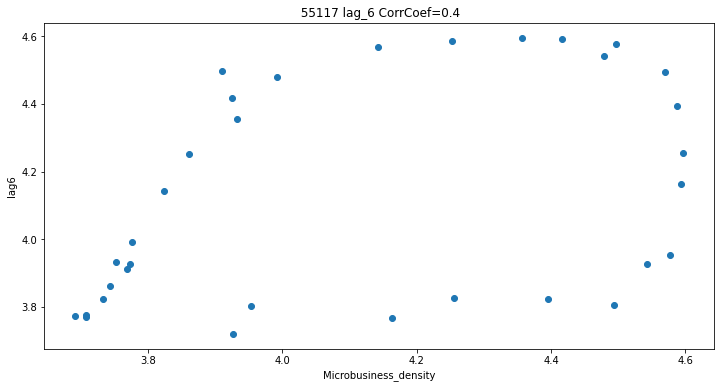

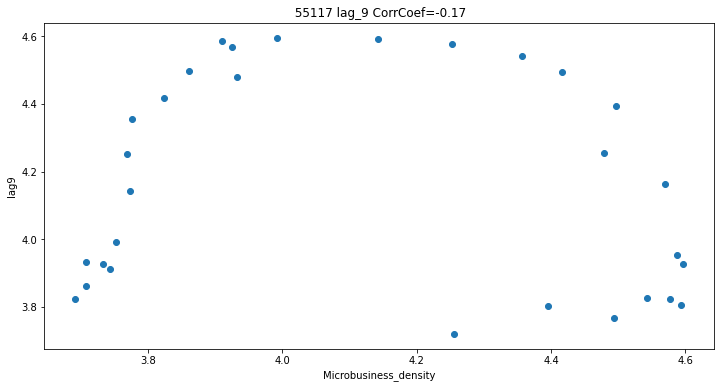

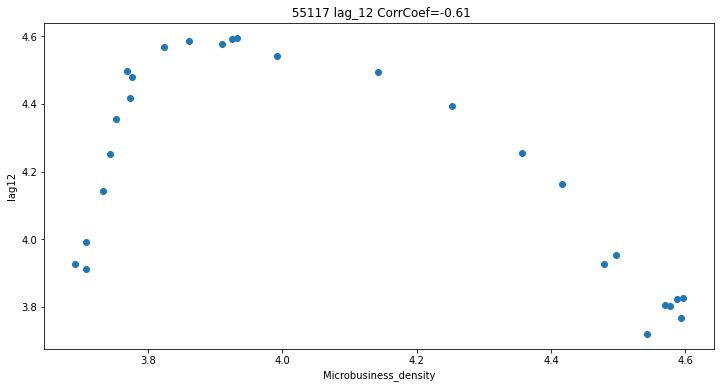

In [11]:
#data[i,]=np.zeros(len(unique_cfips),39)
lag_list=[1,2,3,6,9,12]
for c in cfips_high_err:
    df=train.loc[train.cfips==c,:]
    plot_pacf(df.microbusiness_density,lags=12)
    for i in lag_list:
        df[f'lag_{i}']=df.microbusiness_density.shift(i)
        df=df.fillna(0)
    for i in lag_list:
        plt.figure(figsize=(12,6))
        x=df.microbusiness_density[i:]
        y=df[f'lag_{i}'][i:]
        corr=df['microbusiness_density'][i:].corr(df[f'lag_{i}'][i:])
        plt.scatter(x,y)
        plt.title(f' {c} lag_{i} CorrCoef={round(corr,2)}')
        plt.ylabel(f'lag{i}')
        plt.xlabel('Microbusiness_density')

## More plotting

In [41]:
# def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
#     fig,ax=plt.subplots()
#     scatter_kws=dict(alpha=0.75,s=3)
#     line_kws=dict(color='C3')
#     for i in lag_list:
#         plt.figure(figsize=(12,6))
#         x=df.microbusiness_density[i:]
#         y=df[f'lag_{i}'][i:]
        
#         ax=sns.regplot(x,y,
#                        scatter_kws=scatter_kws,
#                        line_kws=line_kws,
#                        lowess=True,
#                        ax=ax)
        
#         at=AnchoredText((f'{corr}'),
#                         prop=dict(size='large'),
#                         frameon=True,
#                         loc='upper left')
#         at.patch.set_boxstyle('square,pad=0.0')
        
#         corr=x.corr(y)
        
#         plt.title(f' {c} lag_{i} CorrCoef={round(corr,2)}')
#         plt.ylabel(f'lag{i}')
#         plt.xlabel('Microbusiness_density')
    

In [42]:
# def plot_lags(x,y=None,lags=6,nrows=1,lagplot_kwargs={},**kwargs):
#     kwargs.setdefault('nrows',nrows)
#     kwargs.setdefault('ncols',math.ceil(lags/nrows))
#     kwargs.setdefault('figsize',(kwargs['ncols']*2,nrows*2+0.5))
#     fig,axs=plt.subplots(sharex=True,sharey=True,squeeze=False,**kwargs)
#     for ax,k in zip(fig.get_axes()),range(kwargs['nrows']*kwargs['ncols']):
#         if k+1<=lags:
#             ax=lagplot(x,y,lag=k+1,ax=ax,**lagplot_kwargs)
#             ax.set_title(f'Lag{k+1}', ax=ax,**lagplot_kwargs)
#             ax.set(xlabel='',ylabel='')
#         else:
#             ax.axis('off')
#     plt.setp(axs[-1,:],xlabel=x.name)
#     plt.setp(axs[:,0],ylabel=y.name if y is not None else x.name)
#     figh.tight_layout(w_pad=0.1,h_pad=0.1)
#     return fig

In [43]:
# #data[i,]=np.zeros(len(unique_cfips),39)
# lag_list=[1,2,3,6,9,12]
# for c in cfips_high_err:
#     df=train.loc[train.cfips==c,:]
#     plot_pacf(df.microbusiness_density,lags=12)
#     for i in lag_list:
#         df[f'lag_{i}']=df.microbusiness_density.shift(i)
#         df=df.fillna(0)
        
        
# # Plotting
#     fig,ax=plt.subplots()
#     scatter_kws=dict(alpha=0.75,s=3)
#     line_kws=dict(color='C3')
#     for i in lag_list:
#         plt.figure(figsize=(12,6))
#         x=df.microbusiness_density[i:]
#         y=df[f'lag_{i}'][i:]
        
#         ax=sns.regplot(x,y,
#                        scatter_kws=scatter_kws,
#                        line_kws=line_kws,
#                        lowess=True,
#                        ax=ax)
        
#         at=AnchoredText((f'{corr}'),
#                         prop=dict(size='large'),
#                         frameon=True,
#                         loc='upper left')
#         at.patch.set_boxstyle('square,pad=0.0')
        
#         corr=x.corr(y)
        
#         plt.title(f' {c} lag_{i} CorrCoef={round(corr,2)}')
#         plt.ylabel(f'lag{i}')
#         plt.xlabel('Microbusiness_density')

### Insights
1. The data suggests that the lag1 has strong correlation with the actual value.
2. Higher lag have inverse relationship with the actual value.
2. The correlogram show that only lag1 has significant predictor. As such, only lag1 will be used for prediction 

## prediction using lag feature

In [44]:
# THRESHOLD =0.103  #this is 10.3% same value as 8/78 from old notebook
# ACTIVE_THRESHOLD =25_000

# unique_cfips =train.cfips.unique() # return unique cflips
# x_train =np.arange(39).reshape((-1,1))# return (36,1) x_train arrays 
# x_test =np.arange(38,47).reshape((-1,1)) # return (8,1) x_test array

# preds = np.zeros((len(unique_cfips),8),dtype='float')
# last_preds = np.zeros((len(unique_cfips),8),dtype='float')

# R2_score=[]
# cfips_bad_r2score=[]
# cfips_poor_pred=[]
# s_list=[]
# for i,c in enumerate(unique_cfips):
#     df=train.loc[train.cfips==c] # generate data frame for the selected cfips
#     last=df.microbusiness_density.values[-4:-1].mean() # store the mean of last value ( OCT-01,22) as last
    
#     # FIT LINEAR REGRESSION
#     model = LinearRegression()
#     model.fit(x_train,df.microbusiness_density) # fit a linear model
#     p =model.predict(x_train) # predict  
#     R2_score.append(r2_score(p,df.microbusiness_density))
#     # COMPUTE TRAIN ERROR
#     err =p-df.microbusiness_density.values
#     rng = df.microbusiness_density.max()-df.microbusiness_density.min()
    
#     # DETERMIN IF TIME SERIES IS LINEAR OR NOT
#     # create a list of error
#     s=0
#     for k in range(39): # for each month in the training set we will run the function
#         e=np.abs(err[k]) # returns absolute error 
#         r=e/rng #error divided by the actual value
#         s+=r
#     s=s/36 # now S is MAPE mean absolute percentage error
#     # If s is less than 10% then we can assume the county follows linear trend
#        # INFER TEST DATA WITH LINEAR REGRESSION
#     if s>0.103:
#         preds[i,] = [last]*8
#         continue 
#     p2 = model.predict(x_test)
#     shift=last-p2[0]
#     preds[i,]=p2[1:]+shift 
#     #print the cfips with bad r2_score
# #create prediction using lag_1
# df['lag1']=df.microbusiness_density.shift(1)
# df=df.fillna(0)
# x=df.lag1
# y=df.microbusiness_density
# x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.923,shuffle=False)
# #fit and predict
# model=LinearRegression()
# model.fit(x_train,y_train)
# y_pred=pd.Series(model.predict(x_train),index=y_train.index)
# y_fore=pd.Series(model.predict(x_val),index=y_val.index)


In [7]:
mae_list=[]
for c in cfips_high_err:
    df=train.loc[train.cfips==1003,:]
#create prediction using lag_1
    df['lag1']=df.microbusiness_density.shift(1)
    df=df.fillna(0)
    x=df.lag1.values.reshape(-1,1)
    y=df.microbusiness_density.values.reshape(-1)
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.15,shuffle=False)
#fit and predict
    model=LinearRegression()
    model.fit(x_train,y_train)
    y_pred=pd.Series(model.predict(x_train))
    y_fore=pd.Series(model.predict(x_val))
    mae=mean_absolute_percentage_error(y_val,y_fore)
    mae_list.append(mae)

NameError: ignored

In [16]:
x_train[:5]

array([[0.       ],
       [7.2391562],
       [7.2909365],
       [7.4254394],
       [7.4260707]])

In [47]:
y_pred[:5]

0    6.937702
1    7.766727
2    7.772657
3    7.788060
4    7.788132
dtype: float64

In [48]:
x_val[:5]

array([[7.9791703],
       [7.9073648],
       [8.5074959],
       [8.5734634],
       [8.4911499]])

In [49]:
y_fore[:5]

0    7.851473
1    7.843250
2    7.911977
3    7.919531
4    7.910105
dtype: float64

In [50]:
mae_list[:5]

[0.05619995675718351,
 0.05619995675718351,
 0.05619995675718351,
 0.05619995675718351,
 0.05619995675718351]

In [17]:
mae_list1=[]
mae_list2=[]
for c in unique_cfips:
    df=train.loc[train.cfips==c,:]
#create prediction using lag_1
    df['lag1']=df.microbusiness_density.shift(1)
    df=df.fillna(0)
    x_lag=df.lag1.values.reshape(-1,1)
    y_lag=df.microbusiness_density.values.reshape(-1)
#fit and predict
#testsize=0.077
    x_train_lag1,x_val_lag1,y_train_lag1,y_val_lag1=train_test_split(x_lag,y_lag,test_size=0.077,shuffle=False)
    model1=LinearRegression().fit(x_train_lag1,y_train_lag1)
    y_pred_lag1=pd.Series(model1.predict(x_train_lag1))
    y_fore_lag1=pd.Series(model1.predict(x_val_lag1))
    mae1=mean_absolute_percentage_error(y_val_lag1,y_fore_lag1)
    mae_list1.append(mae1)
#testsize=0.2
    x_train_lag2,x_val_lag2,y_train_lag2,y_val_lag2=train_test_split(x_lag,y_lag,test_size=0.205,shuffle=False)
    model2=LinearRegression().fit(x_train_lag2,y_train_lag2)
    y_pred_lag2=pd.Series(model2.predict(x_train_lag2))
    y_fore_lag2=pd.Series(model2.predict(x_val_lag2))
    mae2=mean_absolute_percentage_error(y_val_lag2,y_fore_lag2)
    mae_list2.append(mae2)

In [52]:
mae_list_sor1=sorted(mae_list1,reverse=True)
mae_list_sor1[0:5]

[37385477890165.31,
 2.9632028652272977,
 1.937104114537192,
 1.838057096704893,
 1.2875125292819316]

In [53]:
mae_list_sor2=sorted(mae_list2,reverse=True)
mae_list_sor2[0:5]

[47555425058365.81,
 3.435480748065067,
 3.399883359698034,
 2.8971169613490044,
 2.2987044341940406]

In [56]:
sum(mae_list_sor1[1:])/len(mae_list_sor1[1:])

0.06067163678304745

In [57]:
sum(mae_list_sor2[1:])/len(mae_list_sor2[1:])

0.06579048891203845

In [18]:
mae_list_LR1=[]
mae_list_LR2=[]
for c in unique_cfips:
    df=train.loc[train.cfips==c,:]
#create prediction using lag_1
    x=np.arange(39).reshape((-1,1))
    y=df.microbusiness_density.values.reshape(-1)
    x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.077,shuffle=False)
    
#fit and predict
    model1=LinearRegression().fit(x_train,y_train)
    y_pred=pd.Series(model1.predict(x_train))
    y_fore=pd.Series(model1.predict(x_val))
    mae1=mean_absolute_percentage_error(y_val,y_fore)
    mae_list_LR1.append(mae1)
    
    x_train2,x_val2,y_train2,y_val2=train_test_split(x,y,test_size=0.205,shuffle=False)
    model2=LinearRegression().fit(x_train2,y_train2)
    y_pred2=pd.Series(model2.predict(x_train2))
    y_fore2=pd.Series(model2.predict(x_val2))
    mae2=mean_absolute_percentage_error(y_val2,y_fore2)
    mae_list_LR2.append(mae2)

In [60]:
mae_list_LR_sor1=sorted(mae_list_LR1,reverse=True)
mae_list_LR_sor1[0:5]

[289677628294409.1,
 21.050447949172177,
 7.706658910379762,
 5.819858122333278,
 3.498590686863097]

In [61]:
mae_list_LR_sor2=sorted(mae_list_LR2,reverse=True)
mae_list_LR_sor2[0:5]

[340125348550802.5,
 14.975279626456748,
 9.019527480993446,
 7.76591266745217,
 5.354281069382056]

In [62]:
min(mae_list_LR2)

0.0027665891787341168

In [63]:
sum(mae_list_LR_sor1[1:])/len(mae_list_LR_sor1[1:]),sum(mae_list_LR_sor2[1:])/len(mae_list_LR_sor2[1:])

(0.07588848323417725, 0.08294743780470243)

## Multistep features

In [19]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [26]:
df=train.loc[train.cfips==1001,:]
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


#### multioutput model

In [40]:
def make_lags(data,y,lags,lead_time=1):
  for i in range(lead_time,lags+lead_time):
    data[f'lag_{i}']=y.shift(i).fillna(0)
  return data[f'lag_{i}']

In [ ]:
y=df.microbusiness_density().copy()
x=make_lags(data=df,y=df.microbusiness_density,lags=1,lead_time=1)

In [41]:
def make_multistep_target(data,y,steps):
  for i in range (steps):
    data[f'lag_step_{i+1}']=y.shift(-i)
  return data[f'lag_step_{i+1}']

In [12]:
y[:5]

120873    3.718739
120874    3.800828
120875    3.765968
120876    3.824442
120877    3.822193
Name: lag_12, dtype: float64

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.205,shuffle=False)
model=LinearRegression()
model.fit(x_train,y_train)
y_fit=model.predict(x_train)
y_pred=model.predict(x_test)